In [1]:
import torch
import torch.nn as nn 
#from . import Parameter, config
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import time 
import random
random_seed = 1111
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
#import stheno.torch as stheno

from convcnp.experiment import report_loss, RunningAverage
from convcnp.utils import gaussian_logpdf, init_sequential_weights, to_multiple
from convcnp.architectures import SimpleConv, UNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def to_numpy(x):
    """Convert a PyTorch tensor to NumPy."""
    return x.squeeze().detach().cpu().numpy()





def compute_dists(x, y):
    """Fast computation of pair-wise distances for the 1d case.

    Args:
        x (tensor): Inputs of shape (batch, n, 1).
        y (tensor): Inputs of shape (batch, m, 1).

    Returns:
        tensor: Pair-wise distances of shape (batch, n, m).
    """
    return (x - y.permute(0, 2, 1)) ** 2



def sigmoid2(x):
    return 2*(torch.sigmoid(x)-0.5)
    
from torch.fft import rfftn, irfftn,rfft, irfft

def get_convolved_h(h_grid,nchannel=3):    
    nb,ngrid,nkernels = h_grid.size()
    #permuted_index = np.random.permutation(nkernels)        
    
    #p = np.random.randint(1,nkernels)
    #p=6    
    p = np.random.randint(1,nchannel)
    permuted_index = np.roll(np.arange(nkernels),-p)
    
    #print(p,np.arange(nkernels),permuted_index)
    return convolve_1d_functional_h(h_grid,h_grid[:,:,permuted_index])



def convolve_1d_functional_h(h_i,h_j,target_dim=1,eps=1e-4):
    """
    inputs
        h_i : (nb,ngrids,nchannel)
        h_j : (nb,ngrids,nchannel)    
    outputs
        h_ij : (nb,ngrids,nchannel)
    """
    
    
    if h_i.size(-1) > h_j.size(-1):
        p2d = (0,h_i.size(-1) - h_j.size(-1))
        h_j = F.pad(h_j, p2d, "constant", 0)
    
    
    
    #nhiddens = h_i.size(1)
    nhiddens = h_i.size(target_dim)
    
    if nhiddens % 2 != 0:
        nhiddens -= 1
        h_i = h_i[:,:-1,:]
        h_j = h_j[:,:-1,:]    
    
    f_h_i = rfft(h_i,dim=target_dim)
    f_h_j = rfft(h_j,dim=target_dim)
    

    #plt.scatter(i,(torch.roll(a,shifts=i,dims=-1)*b).sum(dim=1))
    #f_h_i.imag *= -1    
    #n_ij_conv = irfft((f_h_i*f_h_j),dim=target_dim)        
    
    #plt.scatter(i,(a*torch.roll(b,shifts=i,dims=-1)).sum(dim=1))
    f_h_j.imag *= -1    
    n_ij_conv = irfft((f_h_i*f_h_j),dim=target_dim)        
    #n_ij_conv = irfft((f_h_i*f_h_j),dim=target_dim) / (h_i.norm(dim=-1,keepdim=True)*h_j.norm(dim=-1,keepdim=True) + eps)       
    
    #return n_ij_conv/(n_ij_conv.norm(dim=-1,keepdim=True) + eps)
    #return n_ij_conv/(h_i.norm(dim=-1,keepdim=True)*h_j.norm(dim=-1,keepdim=True) + eps)
    return (n_ij_conv-n_ij_conv.mean(dim=1,keepdim=True))/(n_ij_conv.std(dim=1,keepdim=True) + eps)




    
def nchannel_to_single(n_feature,nchannels=3):    
    if n_feature.dim() == 3:
        nb,_,_ = n_feature.size()        
        return n_feature.permute(0,2,1).reshape(nb,-1)
        
    elif n_feature.dim() == 2:
        nb,_ = n_feature.size()                
        return n_feature.reshape(nb,nchannels,-1).permute(0,2,1)
        

    elif n_feature.dim() == 4:
        nb,_,nbasis,nchannels = n_feature.size()           #(nb,ntarget,nbasis,nchannels)              
        n_feature = n_feature.permute(0,2,3,1)        #(nb,nbasis,nchannels,ntarget)   
        n_feature = n_feature.reshape(nb,nbasis,-1).permute(0,2,1)   #(nb,nchannels*ntarget,nbasis) 
        return n_feature
        
        
    else:
        raise NotImplementedError('n_feature.dim() != 2,3,4 ')
    
    


### trainining modules

In [4]:
from torch.distributions.lowrank_multivariate_normal import LowRankMultivariateNormal as Low_MVN
from torch.distributions.multivariate_normal import MultivariateNormal as MVN


def train_epochs(gen_cls,model,opt,ntask=128,nbatch=32,ncontext=32,ntarget=2*32,trainloss='uniform'):
    model.train()
    losses = []
    for _ in range(ntask):
        
        
        context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
                                                                                   ncontext=ncontext,
                                                                                   ntarget=ntarget,
                                                                                   train_range=gen_cls.train_range,
                                                                                   test_range=gen_cls.test_range,
                                                                                   noise_true=True,
                                                                                   intrain = True)

        
        y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())
    
    
        if trainloss == 'uniform':
            loss = []
            obj = -gaussian_logpdf(target_y.cuda(), y_mean, y_std, 'batched_mean')        
        elif trainloss == 'weight':
            loss = []
            for j in range(in_channels):
                loss.append(-gaussian_logpdf(target_y[:,:,j].cuda(), y_mean[:,:,j], y_std[:,:,j], 'batched_mean').unsqueeze(dim=0) )
            loss = torch.cat(loss)
            weights = y_std.mean(dim=(0,1)).detach().clone()
            #print(loss,weights)
            obj = (loss*weights ).mean()
            
        elif trainloss == 'full':
            loss = []
            #m_low
            #m = Low_MVN(torch.zeros(2), torch.tensor([[1.], [0.]]), torch.ones(2))            
            #print(pred_cov[0].size(),pred_cov[1].size())
            m_low = Low_MVN(pred_mean_vec,pred_cov[0],pred_cov[1])
            target_y_vec =  nchannel_to_single(target_y.cuda())            
            obj = -m_low.log_prob(target_y_vec).mean()
            #print(obj)
            
        else :
            pass

        
        # Optimization
        obj.backward()
        opt.step()
        opt.zero_grad()
        
        #losses.append(obj.item())
        losses.append(obj.cpu().data.numpy())        
        
    avg_loss = np.array(losses).mean()
    return avg_loss,loss




def validate_epochs(gen_cls,model,ntask=128,nbatch=32,ncontext=32,ntarget=2*32,train_range= None,test_range=None,intrain=True,trainloss = 'uniform'):
    # large is better 
    model.eval()
    likelihoods = []

    #print(ntask)
    for _ in range(int(ntask)):            
        context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
                                                                                   ncontext=ncontext,
                                                                                   ntarget=ntarget,
                                                                                   train_range=gen_cls.train_range,
                                                                                   test_range=gen_cls.test_range,
                                                                                   noise_true= True,
                                                                                   intrain = intrain)
        
        if trainloss in ['uniform','weight']:
            y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())
            obj = gaussian_logpdf(target_y.cuda(), y_mean, y_std, 'batched_mean')        
        else:
            pred_mean_vec,pred_cov = model(context_x.cuda(),context_y.cuda(),target_x.cuda(),intrain=True) #cov_factor: pred_cov[0], cov_diag: pred_cov[1]           
            m_low = Low_MVN(pred_mean_vec,pred_cov[0],pred_cov[1])
            target_y_vec =  nchannel_to_single(target_y.cuda())            
            obj = m_low.log_prob(target_y_vec).mean()
        
        
        likelihoods.append(obj.cpu().data.numpy())        
        
                
    avg_ll,std_ll = np.array(likelihoods).mean().round(2),(np.array(likelihoods).std()/np.sqrt(ntask)).round(2)
    return avg_ll,std_ll   








from torch.distributions.lowrank_multivariate_normal import LowRankMultivariateNormal as Low_MVN
from torch.distributions.multivariate_normal import MultivariateNormal as MVN

def train_epochs_with_dict(set_dict_epoch,model,opt,trainloss='uniform'):
    model.train()
    losses = []
    
    ntask = set_dict_epoch['context_x'].size(0)
    for ith in range(ntask):
                
        context_x,context_y = set_dict_epoch['context_x'][ith],set_dict_epoch['context_y'][ith]
        target_x,target_y = set_dict_epoch['target_x'][ith],set_dict_epoch['target_y'][ith]
        #print('context_x.size(),target_x.size()')
        #print(context_x.size(),target_x.size(),context_y.size(),target_y.size())

        if trainloss in ['uniform','weight']:
            pred_mean,pred_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())
            #pred_std = 0.1*torch.ones_like(pred_mean).cuda() if pred_mean.is_cuda else  0.1*torch.ones_like(pred_mean).cuda()
            
        else:
            pred_mean_vec,pred_cov = model(context_x.cuda(),context_y.cuda(),target_x.cuda(),intrain=True) #cov_factor: pred_cov[0], cov_diag: pred_cov[1]
            #pred_mean_vec,pred_cov = model(context_x.cuda(),context_y.cuda(),target_x.cuda(),intrain=False)
    
        if trainloss == 'uniform':
            loss = []
            obj = -gaussian_logpdf(target_y.cuda(), pred_mean, pred_std, 'batched_mean')        
        elif trainloss == 'weight':
            loss = []
            for j in range(in_channels):
                loss.append(-gaussian_logpdf(target_y[:,:,j].cuda(), pred_mean[:,:,j], pred_std[:,:,j], 'batched_mean').unsqueeze(dim=0) )
            loss = torch.cat(loss)
            weights = pred_std.mean(dim=(0,1)).detach().clone()
            #print(loss,weights)
            obj = (loss*weights ).mean()
        
        elif trainloss == 'full':
            loss = []
            #m_low
            #m = Low_MVN(torch.zeros(2), torch.tensor([[1.], [0.]]), torch.ones(2))            
            #print(pred_cov[0].size(),pred_cov[1].size())
            m_low = Low_MVN(pred_mean_vec,pred_cov[0],pred_cov[1])
            target_y_vec =  nchannel_to_single(target_y.cuda())            
            obj = -m_low.log_prob(target_y_vec).mean()
            #print(obj)
        
        else :
            pass

        
        # Optimization
        obj.backward()
        opt.step()
        opt.zero_grad()
        
        #losses.append(obj.item())
        losses.append(obj.cpu().data.numpy())        
        
    avg_loss = np.array(losses).mean()
    return avg_loss,loss



def validate_epochs_with_dict(set_dict_epoch,model,test_range=None,trainloss='uniform'):
    # large is better 
    model.eval()
    likelihoods = []
    
    ntask = set_dict_epoch['context_x'].size(0)    
    for ith in range(ntask):        
        
        context_x,context_y = set_dict_epoch['context_x'][ith],set_dict_epoch['context_y'][ith]
        target_x,target_y = set_dict_epoch['target_x'][ith],set_dict_epoch['target_y'][ith]
        
        
        if trainloss in ['uniform','weight']:    
            pred_mean,pred_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())
            #pred_std = 0.1*torch.ones_like(pred_mean).cuda() if pred_mean.is_cuda else  0.1*torch.ones_like(pred_mean).cuda()
            obj = gaussian_logpdf(target_y.cuda(), pred_mean,pred_std, 'batched_mean')        
        else:
            pred_mean_vec,pred_cov = model(context_x.cuda(),context_y.cuda(),target_x.cuda(),intrain=True) #cov_factor: pred_cov[0], cov_diag: pred_cov[1]           
            m_low = Low_MVN(pred_mean_vec,pred_cov[0],pred_cov[1])
            target_y_vec =  nchannel_to_single(target_y.cuda())            
            obj = m_low.log_prob(target_y_vec).mean()
            
            
        likelihoods.append(obj.cpu().data.numpy())        
                
    avg_ll,std_ll = np.array(likelihoods).mean().round(2),(np.array(likelihoods).std()/np.sqrt(ntask)).round(2)
    return avg_ll,std_ll       








In [5]:

# class UNet_Depth3(nn.Module):
#     def __init__(self,in_channels=8):
#         super(UNet_Depth3, self).__init__()
#         self.activation = nn.ReLU()
        
# #         self.in_channels = in_channels
# #         self.out_channels = in_channels
        
#         self.in_channels = in_channels
#         self.out_channels = 2*in_channels
        
#         self.num_halving_layers = 3
#         self.l1 = nn.Conv1d(in_channels=self.in_channels,
#                             out_channels=self.in_channels,
#                             kernel_size=5, stride=2, padding=2)
#         self.l2 = nn.Conv1d(in_channels=self.in_channels,
#                             out_channels=2 * self.in_channels,
#                             kernel_size=5, stride=2, padding=2)
#         self.l3 = nn.Conv1d(in_channels=2 * self.in_channels,
#                             out_channels=4 * self.in_channels,
#                             kernel_size=5, stride=2, padding=2)
# #         self.l4 = nn.Conv1d(in_channels=2 * self.in_channels,
# #                             out_channels=4 * self.in_channels,
# #                             kernel_size=5, stride=2, padding=2)

#         for layer in [self.l1, self.l2, self.l3]:
#             init_layer_weights(layer)

#         self.l4 = nn.ConvTranspose1d(in_channels=4 * self.in_channels,
#                                       out_channels=2 * self.in_channels,
#                                       kernel_size=5, stride=2, padding=2,
#                                       output_padding=1)
#         self.l5 = nn.ConvTranspose1d(in_channels=4 * self.in_channels,
#                                       out_channels=self.in_channels,
#                                       kernel_size=5, stride=2, padding=2,
#                                       output_padding=1)
#         self.l6 = nn.ConvTranspose1d(in_channels=2 * self.in_channels,
#                                       out_channels=self.in_channels,
#                                       kernel_size=5, stride=2, padding=2,
#                                       output_padding=1)

#         for layer in [self.l4, self.l5, self.l6]:
#             init_layer_weights(layer)

            
#     def forward(self, x):
#         """Forward pass through the convolutional structure.

#         Args:
#             x (tensor): Inputs of shape `(batch, n_in, in_channels)`.

#         Returns:
#             tensor: Outputs of shape `(batch, n_out, out_channels)`.
#         """
#         #print('x.shape in conv')
#         #print(x.shape)
        
#         h1 = self.activation(self.l1(x))
#         h2 = self.activation(self.l2(h1))
#         h3 = self.activation(self.l3(h2))
#         h4 = self.activation(self.l4(h3))

#         h4 = pad_concat(h2, h4)
#         h5 = self.activation(self.l5(h4))
#         h5 = pad_concat(h1, h5)
#         h6 = self.activation(self.l6(h5))        
#         #return pad_concat(x, h6)
#         #print(x.size(), h6_[:,-x.size(1):,:].size(),h6.size())
#         #return x + h6_[:,-x.size(1):,:]
        
#         if 2*self.in_channels == self.out_channels:
#             return pad_concat(x, h6)
#         if self.in_channels == self.out_channels:
#             return x + h6
    
#         #return h6

## construct models and train

In [6]:
from model_baseline import ConvCNP_Multi
from model_proposed_new_v1 import ConvCNP_Multi_CC

from model_proposed import ConvCNP_Multicross
from model_proposed_v2 import G_ConvCNP_Multi
from model_proposed_v3 import Cross_ConvCNP
from model_proposed_v4 import Cross_ConvCNP_G,Cross_ConvCNP_L
from model_proposed_new_v1 import ConvCNP_Multi_CC

#from convcnp.architectures import SimpleConv, UNet
from convcnp.utils import (
    init_sequential_weights,
    init_layer_weights,
    pad_concat
)

from convcnp.architectures import SimpleConv, UNet, UNet_Depth3


import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
#import stheno.torch as stheno

from convcnp.cnp_multi import RegressionANP, RegressionCNP
from convcnp.experiment import report_loss, RunningAverage
from convcnp.utils import gaussian_logpdf, init_sequential_weights, to_multiple





iscuda = True
#lr = 1e-3
lr = 5e-4
weight_decay = 1e-4
points_per_unit = 64
#points_per_unit = 32
#points_per_unit = 16

#nbasis = 10
nbasis = 5

#init_l = 0.0001
#init_l = 0.1
#init_l = 0.01
init_l = 0.01

in_channels = nchannels = 3

def build_model(model_type):
    if model_type == 'convcnp':
#         model = ConvCNP_Multi(in_channels=in_channels,
#                               rho = UNet(in_channels**2),
#                               points_per_unit=points_per_unit,
#                               rbf_init_l= init_l,
#                               nbasis = nbasis)

        model = ConvCNP_Multi(in_channels=in_channels,
                              rho = UNet_Depth3(in_channels**2),
                              points_per_unit=points_per_unit,
                              rbf_init_l= init_l,
                              nbasis = nbasis)

    elif model_type == 'propose_n_v1':        
#         model = ConvCNP_Multi_CC(in_channels=in_channels,
#                                   rho = UNet(in_channels**2),
#                                   points_per_unit=points_per_unit,
#                                   rbf_init_l= init_l,
#                                   nbasis = nbasis)

        model = ConvCNP_Multi_CC(in_channels=in_channels,
                                 rho = UNet_Depth3(in_channels**2),
                                 points_per_unit=points_per_unit,
                                 rbf_init_l= init_l,
                                 nbasis = nbasis)    
    
    elif model_type == 'pro-nv2':
        model = ConvCNP_Multi_CC(in_channels=in_channels,
                                 rho = UNet_Depth3(in_channels**2),
                                 cc_rho = UNet_Depth3(in_channels**2),                                 
                                 points_per_unit=points_per_unit,
                                 rbf_init_l= init_l,
                                 nbasis = nbasis)    

        
    elif model_type == 'anp':
        model = RegressionANP(input_dim=nchannels,
                              latent_dim=128,
                              num_channels=nchannels)        
        
        

    elif model_type == 'cnp':
        model = RegressionCNP(input_dim=nchannels,
                              latent_dim=128,
                              num_channels=nchannels)
    else:
        pass
    

    if iscuda:
        model = model.cuda()
    opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
    
    
    return model,opt
    

    

In [8]:
#-------------------------------------------
# train
#------------------------------------------
#tasktype = 'sin3dep'
#tasktype = 'sin3_dep'
tasktype = 'sin3'

#tasktype = 'mosm' #lmc
#tasktype = 'lmc' #lmc

dep = True
testtype = 'extra'
#testtype = 'inter'



In [47]:
from dataset_multi import motask_generator
import time

if testtype == 'inter':
    train_range = [-4,4]
    test_range = [-2,2]
    gen_cls = motask_generator(tasktype=tasktype,testtype=testtype,nchannels=nchannels,train_range=train_range,test_range=test_range,dep=dep)

elif testtype == 'extra':
#     train_range = [-2,2]
#     test_range = [-4,4]
    train_range,test_range = [0,5],[0,10]
    
    gen_cls = motask_generator(tasktype=tasktype,testtype=testtype,nchannels=nchannels,train_range=train_range,test_range=test_range,dep=dep)
else:
    pass


In [48]:
#from multitask_kernel_v4_sin3_withpaper_v2 import build_model
nepochs = 400
model_type='convcnp'
model_convcnp,_ = build_model(model_type=model_type)
saved_modelparam_path = './param_sin3/modeltype{}_trainlossuniform_nepochs{}_lr0.0005.pth'.format(model_type,nepochs)
load_dict = torch.load(saved_modelparam_path)
model_convcnp.load_state_dict(load_dict['state_dict'])       

# model_type='propose_n_v1'
# model_tmp,_ = build_model(model_type=model_type)
# saved_modelparam_path = './param_sin3/modeltype{}_trainlossuniform_nepochs200_lr0.0005.pth'.format(model_type)
# load_dict = torch.load(saved_modelparam_path)
# model_tmp.load_state_dict(load_dict['state_dict'])       

#modeltypeconvcnp_trainlossuniform_nepochs400_lr0.0005
nepochs = 400
model_type='pro-nv2'
model_tmp,_ = build_model(model_type=model_type)
saved_modelparam_path = './param_sin3/modeltype{}_trainlossuniform_nepochs{}_lr0.0005.pth'.format(model_type,nepochs)
load_dict = torch.load(saved_modelparam_path)
model_tmp.load_state_dict(load_dict['state_dict'])       
#modeltypepro-nv2_trainlossuniform_nepochs400_lr0.0005.pth


<All keys matched successfully>

In [49]:
#ncontext=10
# ncontext_list = [10,20,30,50]
# ntarget=100

ntask = 16
nbatch = 16


ncontext_list = [10,20,25,30,50]
#ntarget=50
ntarget=100

#ntask = 120

for ncontext in ncontext_list :
    #print('ncontext {}, ntarget {}'.format(ncontext,ntarget))
    print('#----------------------------------------------------')
    print('convcnp: ntask {}, nbatch {}, ncontext {}, ntarget {}'.format(ntask,nbatch,ncontext,ntarget))
    inrange_train_m,inrange_train_s = validate_epochs(gen_cls,model_convcnp,ntask=ntask,nbatch=16,ncontext=ncontext,ntarget=ntarget,intrain=True)
    outrange_train_m,outrange_train_s = validate_epochs(gen_cls,model_convcnp,ntask=ntask,nbatch=16,ncontext=ncontext,ntarget=ntarget,intrain=False)
    print('intrain testset | val_mnll_mean {:.3f}, val_mnll_std {:.3f}'.format(inrange_train_m,inrange_train_s))           
    print('outtrain testset | te_mnll_mean {:.3f}, te_mnll_std {:.3f}'.format(outrange_train_m,outrange_train_s  ))           

    print('#----------------------------------------------------')
    print('pro-nv2: ntask {}, nbatch {}, ncontext {}, ntarget {}'.format(ntask,nbatch,ncontext,ntarget))    
    inrange_train_m,inrange_train_s = validate_epochs(gen_cls,model_tmp,ntask=ntask,nbatch=16,ncontext=ncontext,ntarget=ntarget,intrain=True)
    outrange_train_m,outrange_train_s = validate_epochs(gen_cls,model_tmp,ntask=ntask,nbatch=16,ncontext=ncontext,ntarget=ntarget,intrain=False)
    print('intrain testset | val_mnll_mean {:.3f}, val_mnll_std {:.3f}'.format(inrange_train_m,inrange_train_s))           
    print('outtrain testset | te_mnll_mean {:.3f}, te_mnll_std {:.3f}'.format(outrange_train_m,outrange_train_s  ))           
    print('\n')
    


#----------------------------------------------------
convcnp: ntask 16, nbatch 16, ncontext 10, ntarget 100
intrain testset | val_mnll_mean -113.880, val_mnll_std 1.370
outtrain testset | te_mnll_mean -113.330, te_mnll_std 0.860
#----------------------------------------------------
pro-nv2: ntask 16, nbatch 16, ncontext 10, ntarget 100
intrain testset | val_mnll_mean -114.710, val_mnll_std 1.300
outtrain testset | te_mnll_mean -116.860, te_mnll_std 1.020


#----------------------------------------------------
convcnp: ntask 16, nbatch 16, ncontext 20, ntarget 100
intrain testset | val_mnll_mean -79.200, val_mnll_std 0.940
outtrain testset | te_mnll_mean -80.240, te_mnll_std 1.140
#----------------------------------------------------
pro-nv2: ntask 16, nbatch 16, ncontext 20, ntarget 100
intrain testset | val_mnll_mean -81.840, val_mnll_std 0.990
outtrain testset | te_mnll_mean -83.930, te_mnll_std 1.550


#----------------------------------------------------
convcnp: ntask 16, nbatch 

In [11]:
#model_convcnp

In [20]:
model_tmp

ConvCNP_Multi_CC(
  (activation): Sigmoid()
  (sigma_fn): Softplus(beta=1, threshold=20)
  (rho): UNet_Depth3(
    (activation): ReLU()
    (l1): Conv1d(9, 9, kernel_size=(5,), stride=(2,), padding=(2,))
    (l2): Conv1d(9, 18, kernel_size=(5,), stride=(2,), padding=(2,))
    (l3): Conv1d(18, 36, kernel_size=(5,), stride=(2,), padding=(2,))
    (l4): ConvTranspose1d(36, 18, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
    (l5): ConvTranspose1d(36, 9, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
    (l6): ConvTranspose1d(18, 9, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,))
  )
  (cc_rho): UNet_Depth3(
    (activation): ReLU()
    (l1): Conv1d(9, 9, kernel_size=(5,), stride=(2,), padding=(2,))
    (l2): Conv1d(9, 18, kernel_size=(5,), stride=(2,), padding=(2,))
    (l3): Conv1d(18, 36, kernel_size=(5,), stride=(2,), padding=(2,))
    (l4): ConvTranspose1d(36, 18, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,)

## computations checks

In [21]:
color_list = ['red','blue','green']
import warnings
warnings.filterwarnings('ignore')

## draw figures 

####################################################################################################


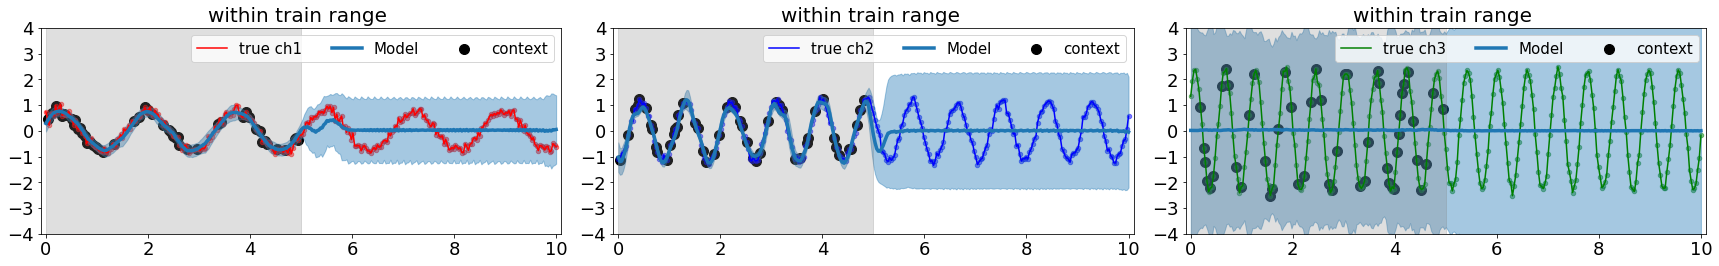

####################################################################################################


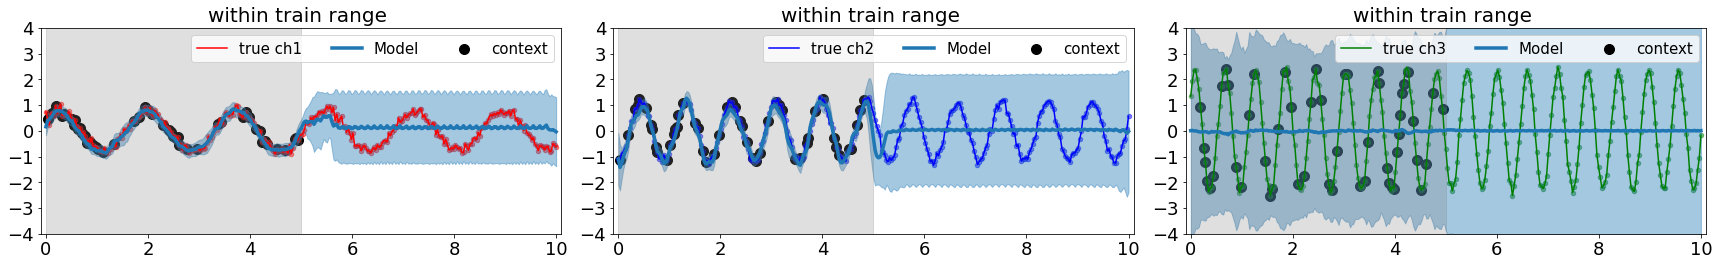

In [51]:
from model_gpbaseline import validate_oracle_epochs_with_dict,gp_predict_batch

# def gaussian_sampler(mu,std,num_sample =5):
#     sample_list = []
#     for i in range(num_sample):
#         tmp = mu + std*torch.randn_like(std)
#         sample_list.append(tmp[None,:,:])
#     return torch.cat(sample_list,dim=0).squeeze()

#xlim_ = [0-0.1,10+0.1]
color_list = ['red','blue','green']

figsiz_ = (24,3.8)

train_range = gen_cls.train_range
test_range = gen_cls.test_range
nbatch=1
#xlim_ = [test_range[0]-0.1,test_range[1]+0.1]
xlim_ = [gen_cls.full_range[0]-0.1,gen_cls.full_range[1]+0.1]
#ylim_ = [-2,2]
ylim_ = [-4,4]

alpha_=0.4

fontsiz_ = 15
fontsiz__ = 18

#------------------------------------------------------
# intrain context
#------------------------------------------------------
#ncontext,ntarget = 8,42
ncontext,ntarget = 50,100

#gen_cls.testtype = 'extra'
gen_cls.testtype = testtype
context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
                                                                         ncontext=ncontext,
                                                                         ntarget=ntarget,
                                                                         train_range = train_range,
                                                                         test_range = test_range,                                                                         
                                                                         noise_true= True,
                                                                         intrain = True)




model_convcnp.eval()
model_tmp.eval()

y_mean0, y_std0 = model_convcnp(context_x.cuda(),context_y.cuda(),full_x.cuda())
y_mean1, y_std1 = model_tmp(context_x.cuda(),context_y.cuda(),full_x.cuda())
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=0.0001)
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=1.0)


y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[0],y_std0.cpu().data.numpy()[0]
y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[0],y_std1.cpu().data.numpy()[0]


context_x_1 = context_x.cpu().data.numpy()[0]
context_y_1 = context_y.cpu().data.numpy()[0]
target_x_1 = target_x.cpu().data.numpy()[0]
target_y_1 = target_y.cpu().data.numpy()[0]
full_x_1 = full_x.cpu().data.numpy()[0]
full_y_1 = full_y.cpu().data.numpy()[0]


nbatch=1


print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
#         plt.scatter(context_x[bidx,:,j],context_y[bidx,:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         plt.plot(full_x[bidx,:,j],y_mean[bidx,:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x[bidx,:,j],
#                          y_mean[bidx,:,j] + 2 * y_std[bidx,:,j],
#                          y_mean[bidx,:,j] - 2 * y_std[bidx,:,j],
#                          color='tab:blue', alpha=alpha_)


        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        #true
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        #model
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




print('#'*100)
y_mean,y_std = y_mean1_1,y_std1_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'

        #true
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        #model       
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()



####################################################################################################


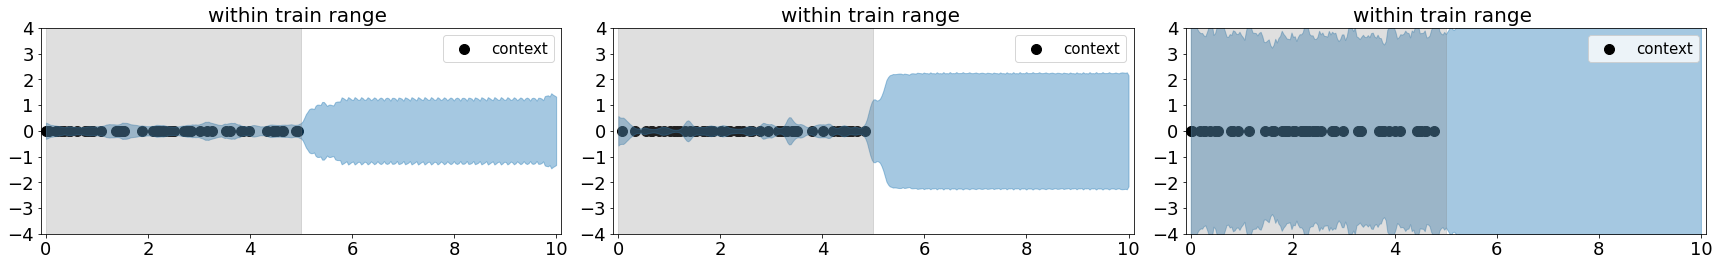

####################################################################################################


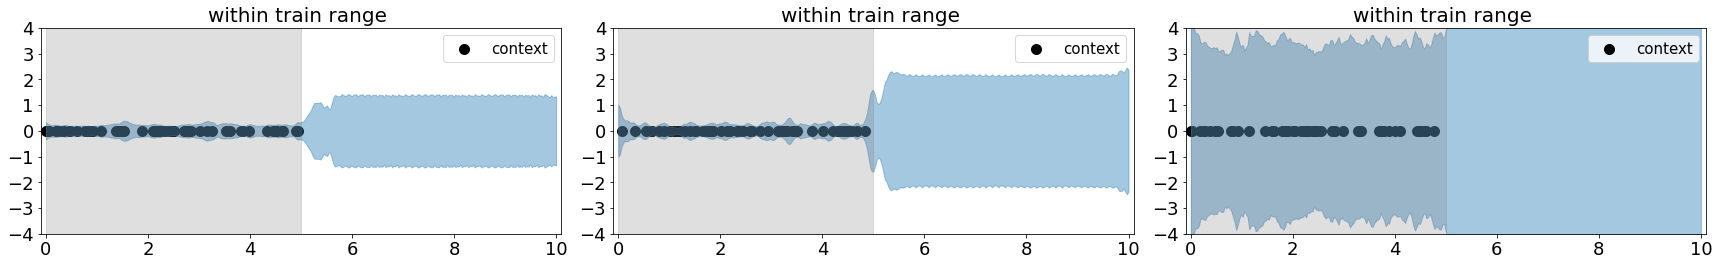

In [52]:
#y_std1_1.shape
from model_gpbaseline import validate_oracle_epochs_with_dict,gp_predict_batch

# def gaussian_sampler(mu,std,num_sample =5):
#     sample_list = []
#     for i in range(num_sample):
#         tmp = mu + std*torch.randn_like(std)
#         sample_list.append(tmp[None,:,:])
#     return torch.cat(sample_list,dim=0).squeeze()

#xlim_ = [0-0.1,10+0.1]
color_list = ['red','blue','green']

figsiz_ = (24,3.8)

train_range = gen_cls.train_range
test_range = gen_cls.test_range
nbatch=2
#xlim_ = [test_range[0]-0.1,test_range[1]+0.1]
xlim_ = [gen_cls.full_range[0]-0.1,gen_cls.full_range[1]+0.1]
#ylim_ = [-2,2]
#ylim_ = [-4,4]
alpha_=0.4

fontsiz_ = 15
fontsiz__ = 18

#------------------------------------------------------
# intrain context
#------------------------------------------------------
#ncontext,ntarget = 8,42
#ncontext,ntarget = 5,100

#gen_cls.testtype = 'extra'
gen_cls.testtype = testtype
context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
                                                                         ncontext=ncontext,
                                                                         ntarget=ntarget,
                                                                         train_range = train_range,
                                                                         test_range = test_range,                                                                         
                                                                         noise_true= False,
                                                                         intrain = True)




# # y_mean0, y_std0 = gp_predict_batch(context_x,context_y,full_x, Ksub=gen_cls.f.Ksub, diag = True)
# # y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[0],y_std0.cpu().data.numpy()[0]

# model.eval()
# y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda())
# y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[0],y_std1.cpu().data.numpy()[0]

# y_mean1, y_std1 = model_tmp(context_x.cuda(),context_y.cuda(),full_x.cuda())


context_x_1 = context_x.cpu().data.numpy()[0]
context_y_1 = context_y.cpu().data.numpy()[0]
target_x_1 = target_x.cpu().data.numpy()[0]
target_y_1 = target_y.cpu().data.numpy()[0]
full_x_1 = full_x.cpu().data.numpy()[0]
full_y_1 = full_y.cpu().data.numpy()[0]


nbatch=1


print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
#         plt.scatter(context_x[bidx,:,j],context_y[bidx,:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         plt.plot(full_x[bidx,:,j],y_mean[bidx,:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x[bidx,:,j],
#                          y_mean[bidx,:,j] + 2 * y_std[bidx,:,j],
#                          y_mean[bidx,:,j] - 2 * y_std[bidx,:,j],
#                          color='tab:blue', alpha=alpha_)


        #dataset
        plt.scatter(context_x_1[:,j],0*context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        
#         plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        #plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         0 + 2 * y_std[:,j],
                         0 - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




print('#'*100)
y_mean,y_std = y_mean1_1,y_std1_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],0*context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        #plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        #plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        #plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         0 + 2 * y_std[:,j],
                         0 - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()



In [53]:
# from model_gpbaseline import validate_oracle_epochs_with_dict,gp_predict_batch

# # def gaussian_sampler(mu,std,num_sample =5):
# #     sample_list = []
# #     for i in range(num_sample):
# #         tmp = mu + std*torch.randn_like(std)
# #         sample_list.append(tmp[None,:,:])
# #     return torch.cat(sample_list,dim=0).squeeze()

# #xlim_ = [0-0.1,10+0.1]
# color_list = ['red','blue','green']

# figsiz_ = (24,3.8)

# train_range = gen_cls.train_range
# test_range = gen_cls.test_range
# nbatch=1
# #xlim_ = [test_range[0]-0.1,test_range[1]+0.1]
# xlim_ = [gen_cls.full_range[0]-0.1,gen_cls.full_range[1]+0.1]
# #ylim_ = [-2,2]
# ylim_ = [-4,4]

# alpha_=0.4

# fontsiz_ = 15
# fontsiz__ = 18

# #------------------------------------------------------
# # intrain context
# #------------------------------------------------------
# #ncontext,ntarget = 8,42
# ncontext,ntarget = 15,100

# #gen_cls.testtype = 'extra'
# gen_cls.testtype = testtype
# context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
#                                                                          ncontext=ncontext,
#                                                                          ntarget=ntarget,
#                                                                          train_range = train_range,
#                                                                          test_range = test_range,                                                                         
#                                                                          noise_true= False,
#                                                                          intrain = True)




# model_convcnp.eval()
# model_tmp.eval()

# y_mean0, y_std0 = model_convcnp(context_x.cuda(),context_y.cuda(),full_x.cuda())
# y_mean1, y_std1 = model_tmp(context_x.cuda(),context_y.cuda(),full_x.cuda(),seperate=True)
# #y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=0.0001)
# #y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=1.0)


# y_mean0_1,y_std0_1 = y_mean1[0].cpu().data.numpy().squeeze(),y_std1[0].cpu().data.numpy().squeeze()
# y_mean1_1,y_std1_1 = y_mean1[1].cpu().data.numpy().squeeze(),y_std1[1].cpu().data.numpy().squeeze()


# context_x_1 = context_x.cpu().data.numpy()[0]
# context_y_1 = context_y.cpu().data.numpy()[0]
# target_x_1 = target_x.cpu().data.numpy()[0]
# target_y_1 = target_y.cpu().data.numpy()[0]
# full_x_1 = full_x.cpu().data.numpy()[0]
# full_y_1 = full_y.cpu().data.numpy()[0]


# #nbatch=1

# print('#'*100)
# y_mean,y_std = y_mean0_1,y_std0_1


# fig = plt.figure(figsize=figsiz_)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

# for bidx in range(nbatch):
#     for j in range(nchannels):
#         plt.subplot(1,3,bidx*nchannels + (j+1))
        
#         #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
#         if gen_cls.testtype == 'inter':
#             plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
#             plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         if gen_cls.testtype == 'extra':
#             plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
#         plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'

#         #true
#         plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
#         #model       
#         plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x_1[:,j],
#                          y_mean[:,j] + 2 * y_std[:,j],
#                          y_mean[:,j] - 2 * y_std[:,j],
#                          color='tab:blue', alpha=alpha_)

        
        
#         plt.ylim(ylim_)
#         plt.xlim(xlim_)
#         plt.xticks(fontsize =  fontsiz__)
#         plt.yticks(fontsize = fontsiz__)
#         #if j == 0:
#         plt.legend(fontsize=fontsiz_,ncol=3)


#         plt.title('within train range ',fontsize= 20)
            
            
# fig.tight_layout()    
# #plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

# plt.show()



# print('#'*100)
# y_mean,y_std = y_mean1_1,y_std1_1


# fig = plt.figure(figsize=figsiz_)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

# for bidx in range(nbatch):
#     for j in range(nchannels):
#         plt.subplot(1,3,bidx*nchannels + (j+1))
        
#         #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
#         if gen_cls.testtype == 'inter':
#             plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
#             plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         if gen_cls.testtype == 'extra':
#             plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
#         plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'

#         #true
#         plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
#         #model       
#         plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x_1[:,j],
#                          y_mean[:,j] + 2 * y_std[:,j],
#                          y_mean[:,j] - 2 * y_std[:,j],
#                          color='tab:blue', alpha=alpha_)

        
        
#         plt.ylim(ylim_)
#         plt.xlim(xlim_)
#         plt.xticks(fontsize =  fontsiz__)
#         plt.yticks(fontsize = fontsiz__)
#         #if j == 0:
#         plt.legend(fontsize=fontsiz_,ncol=3)


#         plt.title('within train range ',fontsize= 20)
            
            
# fig.tight_layout()    
# #plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

# plt.show()


## learned uncertainity check

In [54]:
# #gen_cls.testtype = testtype
# # context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
# #                                                                          ncontext=ncontext,
# #                                                                          ntarget=ntarget,
# #                                                                          train_range = train_range,
# #                                                                          test_range = test_range,                                                                         
# #                                                                          noise_true= False,
# #                                                                          intrain = True)




# model_convcnp.eval()
# model_tmp.eval()


# # y_mean0, y_std0 = gp_predict_batch(context_x,context_y,full_x, Ksub=gen_cls.f.Ksub, diag = True)
# # y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda())
# # gp_samples = gaussian_sampler(y_mean0,y_std0,num_sample=2)
# # model_samples = gaussian_sampler(y_mean1,y_std1,num_sample=2)

# y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[1],y_std0.cpu().data.numpy()[1]
# y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[1],y_std1.cpu().data.numpy()[1]


# context_x_1 = context_x.cpu().data.numpy()[1]
# context_y_1 = context_y.cpu().data.numpy()[1]
# target_x_1 = target_x.cpu().data.numpy()[1]
# target_y_1 = target_y.cpu().data.numpy()[1]
# full_x_1 = full_x.cpu().data.numpy()[1]
# full_y_1 = full_y.cpu().data.numpy()[1]


# print('#'*100)
# y_mean,y_std = y_mean0_1,y_std0_1

# fig = plt.figure(figsize=figsiz_)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

# for bidx in range(nbatch):
#     for j in range(nchannels):
#         plt.subplot(1,3,bidx*nchannels + (j+1))
        
#         #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
#         if gen_cls.testtype == 'inter':
#             plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
#             plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         if gen_cls.testtype == 'extra':
#             plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
# #         #dataset
# #         plt.scatter(context_x[bidx,:,j],context_y[bidx,:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
# #         plt.plot(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
# #         plt.scatter(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
# #         plt.plot(full_x[bidx,:,j],y_mean[bidx,:,j],color='tab:blue',linewidth=3.5,label = 'Model')
# #         plt.fill_between(full_x[bidx,:,j],
# #                          y_mean[bidx,:,j] + 2 * y_std[bidx,:,j],
# #                          y_mean[bidx,:,j] - 2 * y_std[bidx,:,j],
# #                          color='tab:blue', alpha=alpha_)


# #         #dataset
# #         plt.scatter(context_x[:,j],context_y[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
# #         plt.plot(full_x[:,j],full_y[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
# #         plt.scatter(full_x[:,j],full_y[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
# #         plt.plot(full_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
# #         plt.fill_between(full_x[:,j],
# #                          y_mean[:,j] + 2 * y_std[:,j],
# #                          y_mean[:,j] - 2 * y_std[:,j],
# #                          color='tab:blue', alpha=alpha_)


#         #dataset
#         plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x_1[:,j],
#                          y_mean[:,j] + 2 * y_std[:,j],
#                          y_mean[:,j] - 2 * y_std[:,j],
#                          color='tab:blue', alpha=alpha_)

        
        
        
        
#         plt.ylim(ylim_)
#         plt.xlim(xlim_)
#         plt.xticks(fontsize =  fontsiz__)
#         plt.yticks(fontsize = fontsiz__)
#         #if j == 0:
#         plt.legend(fontsize=fontsiz_,ncol=3)


#         plt.title('within train range ',fontsize= 20)
            
            
# fig.tight_layout()    
# #plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

# plt.show()




# print('#'*100)
# y_mean,y_std = y_mean1_1,y_std1_1


# fig = plt.figure(figsize=figsiz_)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

# for bidx in range(nbatch):
#     for j in range(nchannels):
#         plt.subplot(1,3,bidx*nchannels + (j+1))
        
#         #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
#         if gen_cls.testtype == 'inter':
#             plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
#             plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         if gen_cls.testtype == 'extra':
#             plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
# #         plt.scatter(context_x[:,j],context_y[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
# #         plt.plot(full_x[:,j],full_y[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
# #         plt.scatter(full_x[:,j],full_y[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
# #         plt.plot(full_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
# #         plt.fill_between(full_x[:,j],
# #                          y_mean[:,j] + 2 * y_std[:,j],
# #                          y_mean[:,j] - 2 * y_std[:,j],
# #                          color='tab:blue', alpha=alpha_)
        
#         plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x_1[:,j],
#                          y_mean[:,j] + 2 * y_std[:,j],
#                          y_mean[:,j] - 2 * y_std[:,j],
#                          color='tab:blue', alpha=alpha_)        
        
#         plt.ylim(ylim_)
#         plt.xlim(xlim_)
#         plt.xticks(fontsize =  fontsiz__)
#         plt.yticks(fontsize = fontsiz__)
#         #if j == 0:
#         plt.legend(fontsize=fontsiz_,ncol=3)


#         plt.title('within train range ',fontsize= 20)
            
            
# fig.tight_layout()    
# #plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

# plt.show()


In [55]:
# #gen_cls.testtype = testtype
# # context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
# #                                                                          ncontext=ncontext,
# #                                                                          ntarget=ntarget,
# #                                                                          train_range = train_range,
# #                                                                          test_range = test_range,                                                                         
# #                                                                          noise_true= False,
# #                                                                          intrain = True)




# model_convcnp.eval()
# model_tmp.eval()
# # y_mean0, y_std0 = gp_predict_batch(context_x,context_y,full_x, Ksub=gen_cls.f.Ksub, diag = True)
# # y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda())
# # gp_samples = gaussian_sampler(y_mean0,y_std0,num_sample=2)
# # model_samples = gaussian_sampler(y_mean1,y_std1,num_sample=2)

# y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[1],y_std0.cpu().data.numpy()[1]
# y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[1],y_std1.cpu().data.numpy()[1]


# context_x_1 = context_x.cpu().data.numpy()[1]
# context_y_1 = context_y.cpu().data.numpy()[1]
# target_x_1 = target_x.cpu().data.numpy()[1]
# target_y_1 = target_y.cpu().data.numpy()[1]
# full_x_1 = full_x.cpu().data.numpy()[1]
# full_y_1 = full_y.cpu().data.numpy()[1]


# # print('#'*100)
# # y_mean,y_std = y_mean0_1,y_std0_1

# # fig = plt.figure(figsize=figsiz_)
# # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

# # for bidx in range(nbatch):
# #     for j in range(nchannels):
# #         plt.subplot(1,3,bidx*nchannels + (j+1))
        
# #         #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
# #         if gen_cls.testtype == 'inter':
# #             plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
# #             plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
# #         if gen_cls.testtype == 'extra':
# #             plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
# # #         #dataset
# # #         plt.scatter(context_x[bidx,:,j],context_y[bidx,:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
# # #         plt.plot(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
# # #         plt.scatter(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
# # #         plt.plot(full_x[bidx,:,j],y_mean[bidx,:,j],color='tab:blue',linewidth=3.5,label = 'Model')
# # #         plt.fill_between(full_x[bidx,:,j],
# # #                          y_mean[bidx,:,j] + 2 * y_std[bidx,:,j],
# # #                          y_mean[bidx,:,j] - 2 * y_std[bidx,:,j],
# # #                          color='tab:blue', alpha=alpha_)


# # #         #dataset
# # #         plt.scatter(context_x[:,j],context_y[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
# # #         plt.plot(full_x[:,j],full_y[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
# # #         plt.scatter(full_x[:,j],full_y[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
# # #         plt.plot(full_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
# # #         plt.fill_between(full_x[:,j],
# # #                          y_mean[:,j] + 2 * y_std[:,j],
# # #                          y_mean[:,j] - 2 * y_std[:,j],
# # #                          color='tab:blue', alpha=alpha_)


# #         #dataset
# #         plt.scatter(context_x_1[:,j],0*context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
# #         #plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
# #         #plt.scatter(full_x_1[:,j],0*full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
# #         #plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
# #         plt.fill_between(full_x_1[:,j],
# #                          0 + 2 * y_std[:,j],
# #                          0 - 2 * y_std[:,j],
# #                          color='tab:blue', alpha=alpha_)

        
        
        
        
# #         plt.ylim(ylim_)
# #         plt.xlim(xlim_)
# #         plt.xticks(fontsize =  fontsiz__)
# #         plt.yticks(fontsize = fontsiz__)
# #         #if j == 0:
# #         plt.legend(fontsize=fontsiz_,ncol=3)


# #         plt.title('within train range ',fontsize= 20)
            
            
# # fig.tight_layout()    
# # #plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

# # plt.show()




# print('#'*100)
# y_mean,y_std = y_mean1_1,y_std1_1


# fig = plt.figure(figsize=figsiz_)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

# for bidx in range(nbatch):
#     for j in range(nchannels):
#         plt.subplot(1,3,bidx*nchannels + (j+1))
        
#         #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
#         if gen_cls.testtype == 'inter':
#             plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
#             plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         if gen_cls.testtype == 'extra':
#             plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
# #         plt.scatter(context_x[:,j],context_y[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
# #         plt.plot(full_x[:,j],full_y[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
# #         plt.scatter(full_x[:,j],full_y[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
# #         plt.plot(full_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
# #         plt.fill_between(full_x[:,j],
# #                          y_mean[:,j] + 2 * y_std[:,j],
# #                          y_mean[:,j] - 2 * y_std[:,j],
# #                          color='tab:blue', alpha=alpha_)
        
#         plt.scatter(context_x_1[:,j],0*context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
# #         plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
# #         plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
# #         plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x_1[:,j],
#                          0 + 2 * y_std[:,j],
#                          0 - 2 * y_std[:,j],
#                          color='tab:blue', alpha=alpha_)        
        
#         plt.ylim(ylim_)
#         plt.xlim(xlim_)
#         plt.xticks(fontsize =  fontsiz__)
#         plt.yticks(fontsize = fontsiz__)
#         #if j == 0:
#         plt.legend(fontsize=fontsiz_,ncol=3)


#         plt.title('within train range ',fontsize= 20)
            
            
# fig.tight_layout()    
# #plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

# plt.show()


In [56]:
#ylim_ = [-2,2]

####################################################################################################


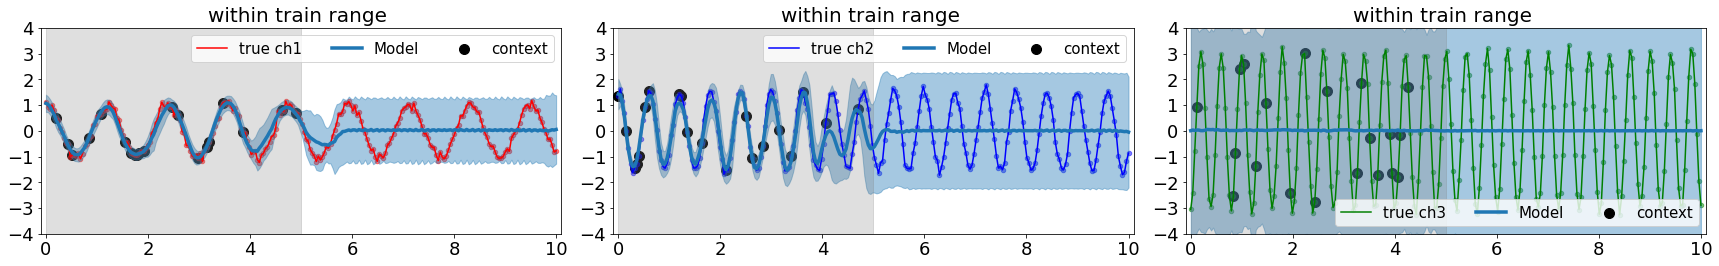

####################################################################################################


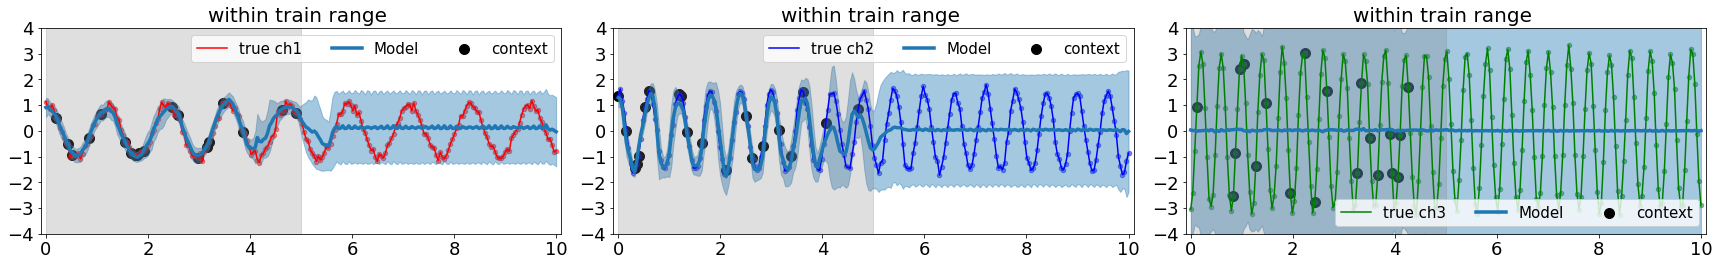

In [57]:
from model_gpbaseline import validate_oracle_epochs_with_dict,gp_predict_batch

# def gaussian_sampler(mu,std,num_sample =5):
#     sample_list = []
#     for i in range(num_sample):
#         tmp = mu + std*torch.randn_like(std)
#         sample_list.append(tmp[None,:,:])
#     return torch.cat(sample_list,dim=0).squeeze()

#xlim_ = [0-0.1,10+0.1]
color_list = ['red','blue','green']

figsiz_ = (24,3.8)

train_range = gen_cls.train_range
test_range = gen_cls.test_range
nbatch=2
#xlim_ = [test_range[0]-0.1,test_range[1]+0.1]
xlim_ = [gen_cls.full_range[0]-0.1,gen_cls.full_range[1]+0.1]
#ylim_ = [-2,2]
#ylim_ = [-4,4]
alpha_=0.4

fontsiz_ = 15
fontsiz__ = 18

#------------------------------------------------------
# intrain context
#------------------------------------------------------
#ncontext,ntarget = 8,42
ncontext,ntarget = 20,100
#ncontext,ntarget = 25,100

#gen_cls.testtype = 'extra'
gen_cls.testtype = testtype
context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
                                                                         ncontext=ncontext,
                                                                         ntarget=ntarget,
                                                                         train_range = train_range,
                                                                         test_range = test_range,                                                                         
                                                                         noise_true= True,
                                                                         intrain = True)




model_convcnp.eval()
model_tmp.eval()


y_mean0, y_std0 = model_convcnp(context_x.cuda(),context_y.cuda(),full_x.cuda())
y_mean1, y_std1 = model_tmp(context_x.cuda(),context_y.cuda(),full_x.cuda())
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=0.0001)
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=1.0)


y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[0],y_std0.cpu().data.numpy()[0]
y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[0],y_std1.cpu().data.numpy()[0]


context_x_1 = context_x.cpu().data.numpy()[0]
context_y_1 = context_y.cpu().data.numpy()[0]
target_x_1 = target_x.cpu().data.numpy()[0]
target_y_1 = target_y.cpu().data.numpy()[0]
full_x_1 = full_x.cpu().data.numpy()[0]
full_y_1 = full_y.cpu().data.numpy()[0]


nbatch=1


print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
#         plt.scatter(context_x[bidx,:,j],context_y[bidx,:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         plt.plot(full_x[bidx,:,j],y_mean[bidx,:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x[bidx,:,j],
#                          y_mean[bidx,:,j] + 2 * y_std[bidx,:,j],
#                          y_mean[bidx,:,j] - 2 * y_std[bidx,:,j],
#                          color='tab:blue', alpha=alpha_)


        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        #true
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        #model
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




print('#'*100)
y_mean,y_std = y_mean1_1,y_std1_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'

        #true
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        #model
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()



## used for table

####################################################################################################


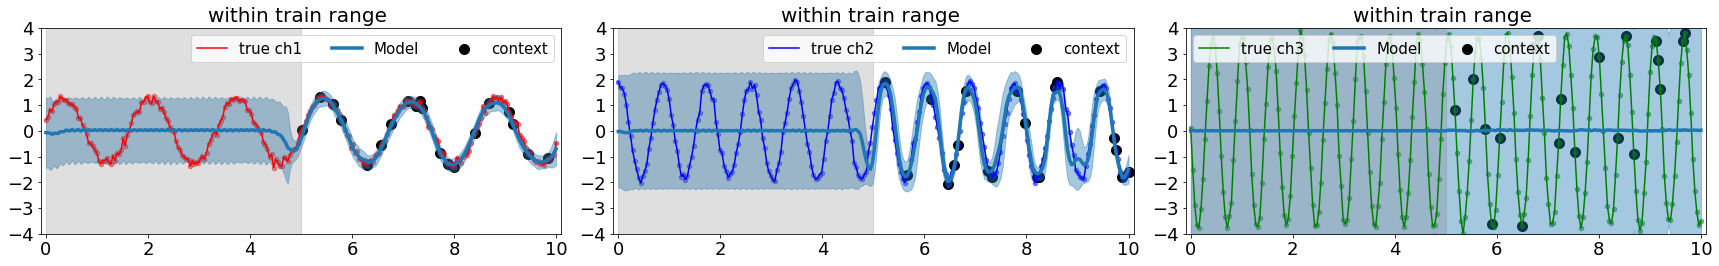

####################################################################################################


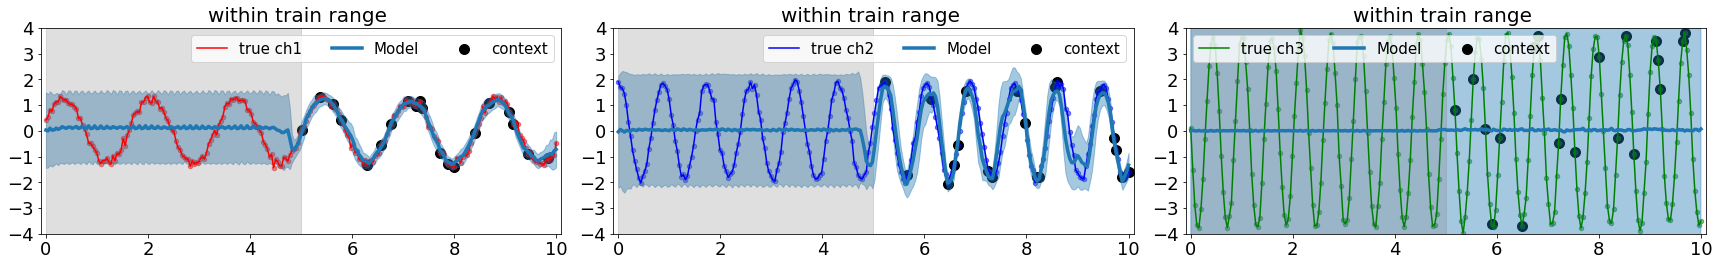

In [58]:
#xlim_ = [0-0.1,10+0.1]

figsiz_ = (24,3.8)

train_range = gen_cls.train_range
test_range = gen_cls.test_range
nbatch=2
#xlim_ = [test_range[0]-0.1,test_range[1]+0.1]
xlim_ = [gen_cls.full_range[0]-0.1,gen_cls.full_range[1]+0.1]
#ylim_ = [-2,2]
ylim_ = [-4,4]

fontsiz_ = 15
fontsiz__ = 18

#------------------------------------------------------
# intrain context
#------------------------------------------------------


#gen_cls.testtype = 'extra'
gen_cls.testtype = testtype
context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
                                                                         ncontext=ncontext,
                                                                         ntarget=ntarget,
                                                                         train_range = train_range,
                                                                         test_range = test_range,                                                                         
                                                                         noise_true=True,
                                                                         intrain = False)


model_convcnp.eval()
model_tmp.eval()


y_mean0, y_std0 = model_convcnp(context_x.cuda(),context_y.cuda(),full_x.cuda())
y_mean1, y_std1 = model_tmp(context_x.cuda(),context_y.cuda(),full_x.cuda())
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=0.0001)
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=1.0)


y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[0],y_std0.cpu().data.numpy()[0]
y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[0],y_std1.cpu().data.numpy()[0]


context_x_1 = context_x.cpu().data.numpy()[0]
context_y_1 = context_y.cpu().data.numpy()[0]
target_x_1 = target_x.cpu().data.numpy()[0]
target_y_1 = target_y.cpu().data.numpy()[0]
full_x_1 = full_x.cpu().data.numpy()[0]
full_y_1 = full_y.cpu().data.numpy()[0]


nbatch=1


print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
#         plt.scatter(context_x[bidx,:,j],context_y[bidx,:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         plt.plot(full_x[bidx,:,j],y_mean[bidx,:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x[bidx,:,j],
#                          y_mean[bidx,:,j] + 2 * y_std[bidx,:,j],
#                          y_mean[bidx,:,j] - 2 * y_std[bidx,:,j],
#                          color='tab:blue', alpha=alpha_)


        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




print('#'*100)
y_mean,y_std = y_mean1_1,y_std1_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()


####################################################################################################


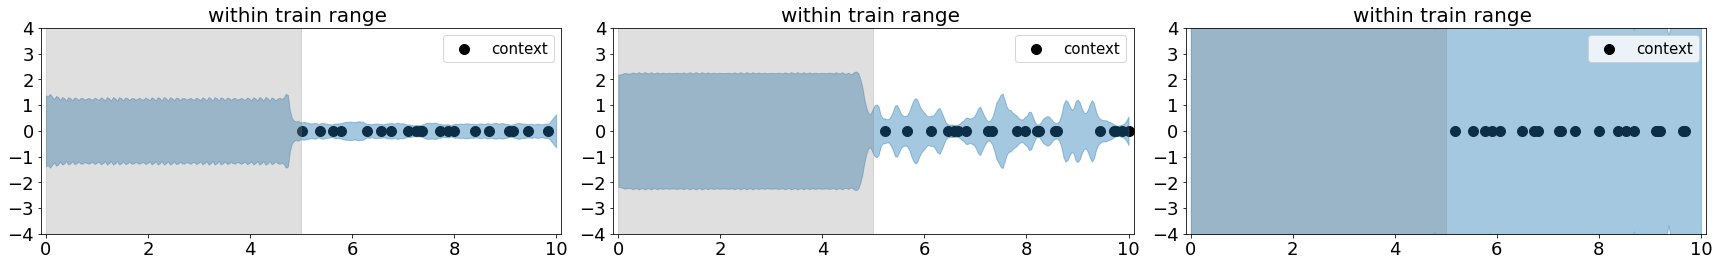

####################################################################################################


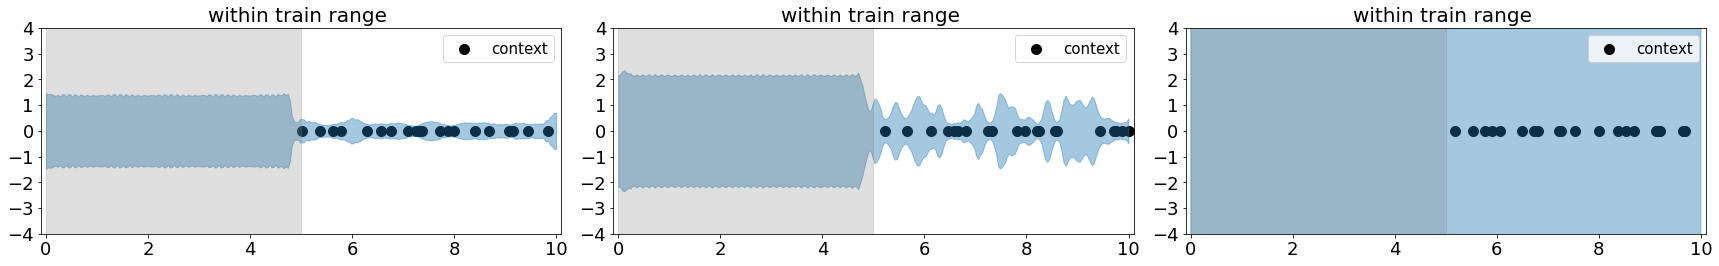

In [59]:
#xlim_ = [0-0.1,10+0.1]

figsiz_ = (24,3.8)

train_range = gen_cls.train_range
test_range = gen_cls.test_range
nbatch=2
#xlim_ = [test_range[0]-0.1,test_range[1]+0.1]
xlim_ = [gen_cls.full_range[0]-0.1,gen_cls.full_range[1]+0.1]
#ylim_ = [-2,2]
#ylim_ = [-5,5]

fontsiz_ = 15
fontsiz__ = 18

#------------------------------------------------------
# intrain context
#------------------------------------------------------


#gen_cls.testtype = 'extra'
# gen_cls.testtype = testtype
# context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
#                                                                          ncontext=ncontext,
#                                                                          ntarget=ntarget,
#                                                                          train_range = train_range,
#                                                                          test_range = test_range,                                                                         
#                                                                          noise_true=False,
#                                                                          intrain = False)


model_convcnp.eval()
model_tmp.eval()

y_mean0, y_std0 = model_convcnp(context_x.cuda(),context_y.cuda(),full_x.cuda())
y_mean1, y_std1 = model_tmp(context_x.cuda(),context_y.cuda(),full_x.cuda())
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=0.0001)
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=1.0)


y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[0],y_std0.cpu().data.numpy()[0]
y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[0],y_std1.cpu().data.numpy()[0]



context_x_1 = context_x.cpu().data.numpy()[0]
context_y_1 = context_y.cpu().data.numpy()[0]
target_x_1 = target_x.cpu().data.numpy()[0]
target_y_1 = target_y.cpu().data.numpy()[0]
full_x_1 = full_x.cpu().data.numpy()[0]
full_y_1 = full_y.cpu().data.numpy()[0]


nbatch=1


print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
#         plt.scatter(context_x[bidx,:,j],context_y[bidx,:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         plt.plot(full_x[bidx,:,j],y_mean[bidx,:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x[bidx,:,j],
#                          y_mean[bidx,:,j] + 2 * y_std[bidx,:,j],
#                          y_mean[bidx,:,j] - 2 * y_std[bidx,:,j],
#                          color='tab:blue', alpha=alpha_)


        #dataset
        plt.scatter(context_x_1[:,j],0*context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        #plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        #plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        #plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         0*y_mean[:,j] + 2 * y_std[:,j],
                         0*y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




print('#'*100)
y_mean,y_std = y_mean1_1,y_std1_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],0*context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         0*y_mean[:,j] + 2 * y_std[:,j],
                         0*y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()


####################################################################################################


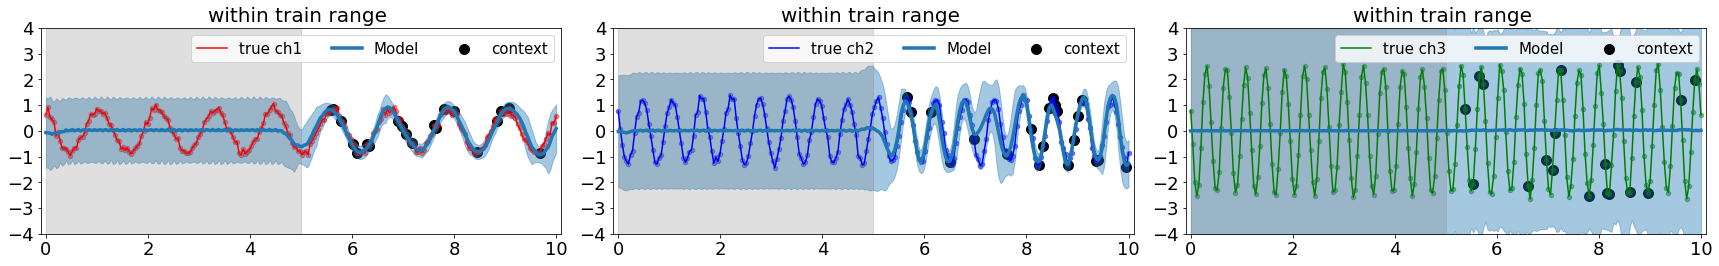

####################################################################################################


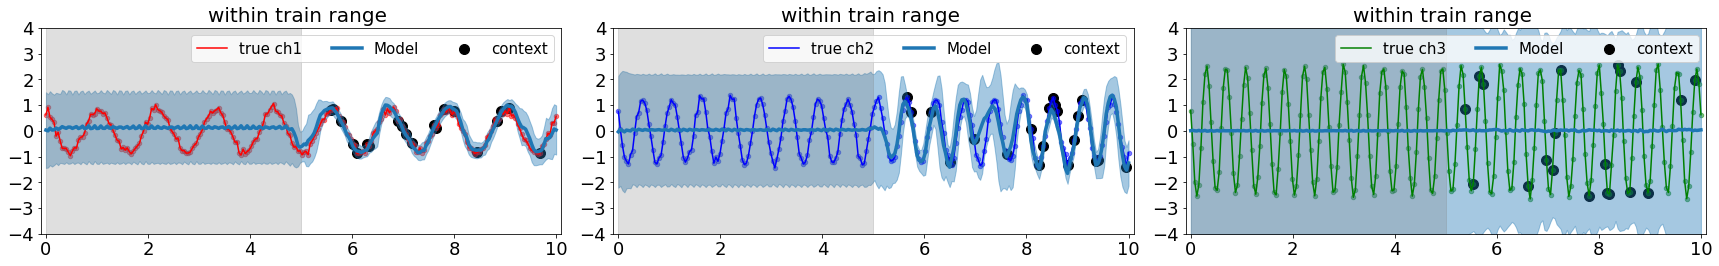

In [60]:
#gen_cls.testtype = testtype
# context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
#                                                                          ncontext=ncontext,
#                                                                          ntarget=ntarget,
#                                                                          train_range = train_range,
#                                                                          test_range = test_range,                                                                         
#                                                                          noise_true=False,
#                                                                          intrain = False)



model_convcnp.eval()
model_tmp.eval()


y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[1],y_std0.cpu().data.numpy()[1]
y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[1],y_std1.cpu().data.numpy()[1]



context_x_1 = context_x.cpu().data.numpy()[1]
context_y_1 = context_y.cpu().data.numpy()[1]
target_x_1 = target_x.cpu().data.numpy()[1]
target_y_1 = target_y.cpu().data.numpy()[1]
full_x_1 = full_x.cpu().data.numpy()[1]
full_y_1 = full_y.cpu().data.numpy()[1]


print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        

        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()






print('#'*100)
y_mean,y_std = y_mean1_1,y_std1_1
fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
#         plt.scatter(context_x[:,j],context_y[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x[:,j],full_y[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x[:,j],full_y[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         plt.plot(full_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x[:,j],
#                          y_mean[:,j] + 2 * y_std[:,j],
#                          y_mean[:,j] - 2 * y_std[:,j],
#                          color='tab:blue', alpha=alpha_)
        
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()


In [34]:
# #xlim_ = [0-0.1,10+0.1]

# figsiz_ = (24,3.8)

# train_range = gen_cls.train_range
# test_range = gen_cls.test_range
# nbatch=2
# #xlim_ = [test_range[0]-0.1,test_range[1]+0.1]
# xlim_ = [gen_cls.full_range[0]-0.1,gen_cls.full_range[1]+0.1]
# #ylim_ = [-2,2]
# #ylim_ = [-5,5]

# fontsiz_ = 15
# fontsiz__ = 18

# #------------------------------------------------------
# # intrain context
# #------------------------------------------------------


# gen_cls.testtype = 'extra'
# gen_cls.testtype = testtype
# context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
#                                                                          ncontext=ncontext,
#                                                                          ntarget=ntarget,
#                                                                          train_range = train_range,
#                                                                          test_range = test_range,                                                                         
#                                                                          noise_true=False,
#                                                                          intrain = False)


# model_convcnp.eval()
# model_tmp.eval()

# y_mean0, y_std0 = model_convcnp(context_x.cuda(),context_y.cuda(),full_x.cuda())
# y_mean1, y_std1 = model_tmp(context_x.cuda(),context_y.cuda(),full_x.cuda())
# #y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=0.0001)
# #y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=1.0)




# y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[0],y_std0.cpu().data.numpy()[0]
# y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[0],y_std1.cpu().data.numpy()[0]


# context_x_1 = context_x.cpu().data.numpy()[0]
# context_y_1 = context_y.cpu().data.numpy()[0]
# target_x_1 = target_x.cpu().data.numpy()[0]
# target_y_1 = target_y.cpu().data.numpy()[0]
# full_x_1 = full_x.cpu().data.numpy()[0]
# full_y_1 = full_y.cpu().data.numpy()[0]


# nbatch=1


# print('#'*100)
# y_mean,y_std = y_mean0_1,y_std0_1

# fig = plt.figure(figsize=figsiz_)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

# for bidx in range(nbatch):
#     for j in range(nchannels):
#         plt.subplot(1,3,bidx*nchannels + (j+1))
        
#         #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
#         if gen_cls.testtype == 'inter':
#             plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
#             plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         if gen_cls.testtype == 'extra':
#             plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
# #         #dataset
# #         plt.scatter(context_x[bidx,:,j],context_y[bidx,:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
# #         plt.plot(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
# #         plt.scatter(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
# #         plt.plot(full_x[bidx,:,j],y_mean[bidx,:,j],color='tab:blue',linewidth=3.5,label = 'Model')
# #         plt.fill_between(full_x[bidx,:,j],
# #                          y_mean[bidx,:,j] + 2 * y_std[bidx,:,j],
# #                          y_mean[bidx,:,j] - 2 * y_std[bidx,:,j],
# #                          color='tab:blue', alpha=alpha_)


#         #dataset
#         plt.scatter(context_x_1[:,j],0*context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         #plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         #plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         #plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x_1[:,j],
#                          0*y_mean[:,j] + 2 * y_std[:,j],
#                          0*y_mean[:,j] - 2 * y_std[:,j],
#                          color='tab:blue', alpha=alpha_)

        
        
#         plt.ylim(ylim_)
#         plt.xlim(xlim_)
#         plt.xticks(fontsize =  fontsiz__)
#         plt.yticks(fontsize = fontsiz__)
#         #if j == 0:
#         plt.legend(fontsize=fontsiz_,ncol=3)


#         plt.title('within train range ',fontsize= 20)
            
            
# fig.tight_layout()    
# #plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

# plt.show()




# print('#'*100)
# y_mean,y_std = y_mean1_1,y_std1_1


# fig = plt.figure(figsize=figsiz_)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

# for bidx in range(nbatch):
#     for j in range(nchannels):
#         plt.subplot(1,3,bidx*nchannels + (j+1))
        
#         #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
#         if gen_cls.testtype == 'inter':
#             plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
#             plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         if gen_cls.testtype == 'extra':
#             plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
#         plt.scatter(context_x_1[:,j],0*context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
# #         plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
# #         plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
# #        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x_1[:,j],
#                          0*y_mean[:,j] + 2 * y_std[:,j],
#                          0*y_mean[:,j] - 2 * y_std[:,j],
#                          color='tab:blue', alpha=alpha_)

        
        
#         plt.ylim(ylim_)
#         plt.xlim(xlim_)
#         plt.xticks(fontsize =  fontsiz__)
#         plt.yticks(fontsize = fontsiz__)
#         #if j == 0:
#         plt.legend(fontsize=fontsiz_,ncol=3)


#         plt.title('within train range ',fontsize= 20)
            
            
# fig.tight_layout()    
# #plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

# plt.show()


In [35]:
# from torch.autograd import Variable


# x_grid = model.compute_xgrid(context_x[:3].cuda(),context_y[:3].cuda(),target_x[:3].cuda())
# n_h1,_,h1,h0 = model.encoder(context_x[:3].cuda(), context_y[:3].cuda(), x_grid)

# cc_n_h1 = get_convolved_h(n_h1,nchannel=model.in_channels)
# #rand_noise = Variable(torch.randn(cc_n_h1.size(0),1,cc_n_h1.size(-1)).cuda(),requires_grad=False)
# rand_noise = Variable(torch.rand(1).cuda(),requires_grad=False)
# n_h1_ = n_h1 + (1-h0).clamp(min=1e-8,max=None)*cc_n_h1


# nh_sm.size()
# # nh_sm_v1= model.compute_hgrid(nh_sm)
# # nh_sm_v1 = nh_sm_v1.view(nh_sm.size(0),nh_sm.size(1),-1)


# nh_sm_v1 = model.compute_hgrid_tmp(n_h1,option='mean')
# nh_sm_v1 = nh_sm_v1.view(nh_sm_v1.size(0),nh_sm_v1.size(1),-1)
# nh_sm_v2 = model.compute_hgrid_tmp(h0,option='var')
# nh_sm_v2 = nh_sm_v2.view(nh_sm_v2.size(0),nh_sm_v2.size(1),-1)





# ib = 0
# fontsiz_=19
# plt.figure(figsize=(20,3*5))

# plt.subplot(5,1,1)        
# for i in range(9):
#     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),h0[ib,:,i].cpu().data.numpy(),label = str(i))    
#     plt.scatter(context_x[ib,:,i%3].cpu().data.numpy(),0*context_y[ib,:,i%3].cpu().data.numpy(),label = str(i))
    
#     #plt.scatter(context_x[ib,i].cpu().data.numpy(),context_y[ib,i].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('h0',fontsize=fontsiz_)            
# plt.legend()        
# plt.ylim(ylim_)        


# plt.subplot(5,1,2)        
# for i in range(9):
#     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),nh_sm_v2[ib,:,i].cpu().data.numpy(),label = str(i))    
#     #plt.scatter(context_x[ib,i].cpu().data.numpy(),context_y[ib,i].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('h0',fontsize=fontsiz_)            
# plt.legend()        
# plt.ylim(ylim_)        


# plt.subplot(5,1,3)
# for i in range(9):
#     #plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),nh_sm[ib,:,i].cpu().data.numpy(),label = str(i))
    
#     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(), n_h1[ib,:,i].cpu().data.numpy(),label = str(i))
#     #plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(), (0.5*torch.randn_like(nh_sm[ib,:,i]) + nh_sm[ib,:,i]).cpu().data.numpy(),label = str(i))    
    
#     plt.scatter(context_x[ib,:,i%3].cpu().data.numpy(),context_y[ib,:,i%3].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('h1',fontsize=fontsiz_)    
# plt.legend()        
# plt.ylim(ylim_)        

# plt.subplot(5,1,4)
# for i in range(9):
#     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),cc_n_h1[ib,:,i].cpu().data.numpy(),label = str(i))
#     plt.scatter(context_x[ib,:,i%3].cpu().data.numpy(),context_y[ib,:,i%3].cpu().data.numpy(),label = str(i))    
#     #plt.scatter(context_x[ib,:,i%3].cpu().data.numpy(),context_y[ib,:,i%3].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('h1_convolved',fontsize=fontsiz_)    
# #plt.legend()        
# plt.ylim(ylim_)        


# plt.subplot(5,1,5)
# for i in range(9):
#     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(), n_h1_[ib,:,i].cpu().data.numpy(),label = str(i))
#     plt.scatter(context_x[ib,:,i%3].cpu().data.numpy(),context_y[ib,:,i%3].cpu().data.numpy(),label = str(i))    
#     #plt.scatter(context_x[ib,:,i%3].cpu().data.numpy(),context_y[ib,:,i%3].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('h1_convolved',fontsize=fontsiz_)    
# #plt.legend()        
# plt.ylim(ylim_)        

# # nh_sm_c = get_convolved_h(nh_sm)    
# # plt.subplot(4,1,4)
# # for i in range(9):
# #     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),nh_sm_c[ib,:,i].cpu().data.numpy(),label = str(i))
# #     plt.scatter(context_x[ib,:,i%3].cpu().data.numpy(),context_y[ib,:,i%3].cpu().data.numpy(),label = str(i))    
# #     #plt.scatter(context_x[ib,:,i%3].cpu().data.numpy(),context_y[ib,:,i%3].cpu().data.numpy(),label = str(i))
# #     if i == 0:
# #         plt.title('h1_convolved',fontsize=fontsiz_)    
# #plt.legend()        
# #plt.ylim([-3,3])        
    

# print('\n'*2)
    
    
    
# #ib = 0
# #fontsiz_=19
# # plt.figure(figsize=(20,4))
# # plt.subplot(2,1,1)
# # #for i in range(3):
# # for i in range(9):
# #     plt.plot(x_grid[ib,:,i//3].cpu().data.numpy(),nh_sm[ib,:,i].cpu().data.numpy(),label = str(i))
# #     if i == 0:
# #         plt.title('model.encoder',fontsize=fontsiz_)    
# # plt.legend()        
        
# # plt.subplot(2,1,2)        
# # for i in range(3):
# #     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),nh_sm[ib,:,i].cpu().data.numpy(),label = str(i))
# #     if i == 0:
# #         plt.title('model.encoder',fontsize=fontsiz_)    
        
# # plt.legend()        
# plt.show()
# print('\n'*2)

# ib = 0
# plt.figure(figsize=(20,4))
# for i in range(9):
# #for i in range(4,6):    
#     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),nh_sm_v1[ib,:,i].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('model.compute_hgrid',fontsize=fontsiz_)    
# plt.legend()        
# plt.show()


# plt.figure(figsize=(20,4))
# for i in range(9):
# #for i in range(4,6):    
#     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),nh_sm_v2[ib,:,i].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('model.compute_hgrid',fontsize=fontsiz_)    
# plt.legend()        
# plt.show()


# #ib = 0
# # plt.figure(figsize=(20,4))
# # for i in range(18):
# # #for i in range(4,6):    
# #     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),nh_sm_v2[ib,:,i].cpu().data.numpy(),label = str(i))
# #     if i == 0:
# #         plt.title('model.compute_hgrid',fontsize=fontsiz_)    
# # plt.legend()        
# # plt.show()

# print('\n'*3)

In [36]:
# x_grid = model.compute_xgrid(context_x.cuda(),context_y.cuda(),full_x.cuda())
# nh_sm,h1,h0 = model.encoder(context_x.cuda(), context_y.cuda(), x_grid)

# nh_sm.size()
# nh_sm_v1 = model.compute_hgrid(nh_sm)
# #nh_sm_v1,nh_sm_v2 = model.compute_hgrid(nh_sm,h0)

# #nh_sm_v1.size()
# #nh_sm_v1 = nh_sm_v1.view(3,272,-1)
# nh_sm_v1 = nh_sm_v1.view(nh_sm_v1.size(0),nh_sm_v1.size(1),-1)
# #nh_sm_v2 = nh_sm_v2.view(nh_sm_v2.size(0),nh_sm_v2.size(1),-1)







     

# ib = 0
# fontsiz_=19
# plt.figure(figsize=(20,4))
# plt.subplot(2,1,1)
# for i in range(9):
#     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),h1[ib,:,i].cpu().data.numpy(),label = str(i))
#     plt.scatter(context_x[ib,:,i%3].cpu().data.numpy(),context_y[ib,:,i%3].cpu().data.numpy(),label = str(i))
    
#     #plt.plot(h1[ib,:,i].cpu().data.numpy(),label = str(i))
    
#     if i == 0:
#         plt.title('h1',fontsize=fontsiz_)    
# plt.legend()        
        
# plt.subplot(2,1,2)        
# for i in range(9):
#     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),h0[ib,:,i].cpu().data.numpy(),label = str(i))    
#     plt.scatter(context_x[ib,:,i%3].cpu().data.numpy(),0*context_y[ib,:,i%3].cpu().data.numpy(),label = str(i))
    
#     #plt.scatter(context_x[ib,i].cpu().data.numpy(),context_y[ib,i].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('h0',fontsize=fontsiz_)    
        
# plt.legend()        
# plt.show()
# print('\n'*2)
    
    
# #ib = 0
# #fontsiz_=19
# plt.figure(figsize=(20,4))
# plt.subplot(2,1,1)
# #for i in range(3):
# for i in range(9):
#     plt.plot(x_grid[ib,:,i//3].cpu().data.numpy(),nh_sm[ib,:,i].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('model.encoder',fontsize=fontsiz_)    
# plt.legend()        
        
# # plt.subplot(2,1,2)        
# # for i in range(3):
# #     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),nh_sm[ib,:,i].cpu().data.numpy(),label = str(i))
# #     if i == 0:
# #         plt.title('model.encoder',fontsize=fontsiz_)    
        
# # plt.legend()        
# plt.show()
# print('\n'*2)

# ib = 0
# plt.figure(figsize=(20,4))
# for i in range(18):
# #for i in range(4,6):    
#     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),nh_sm_v1[ib,:,i].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('model.compute_hgrid',fontsize=fontsiz_)    
# plt.legend()        
# plt.show()


# # plt.figure(figsize=(20,4))
# # ib = 0
# # plt.figure(figsize=(20,4))
# # for i in range(18):
# # #for i in range(4,6):    
# #     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),nh_sm_v2[ib,:,i].cpu().data.numpy(),label = str(i))
# #     if i == 0:
# #         plt.title('model.compute_hgrid',fontsize=fontsiz_)    
# # plt.legend()        
# # plt.show()

# print('\n'*3)

In [37]:
#tmpmodel.mean_layer.sigma.exp(),model.logstd_layer.sigma.exp()
model_convcnp.num_params,model_tmp.num_params

(10617, 21284.0)

## full range

####################################################################################################


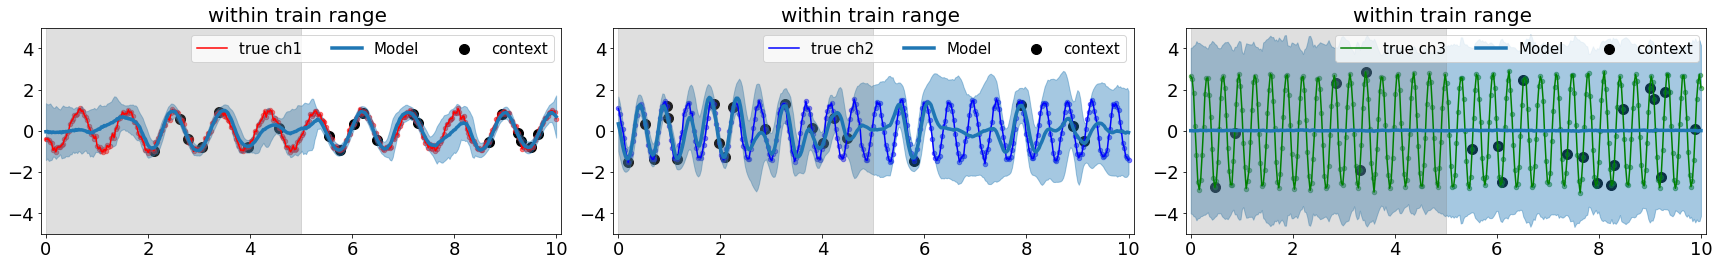

####################################################################################################


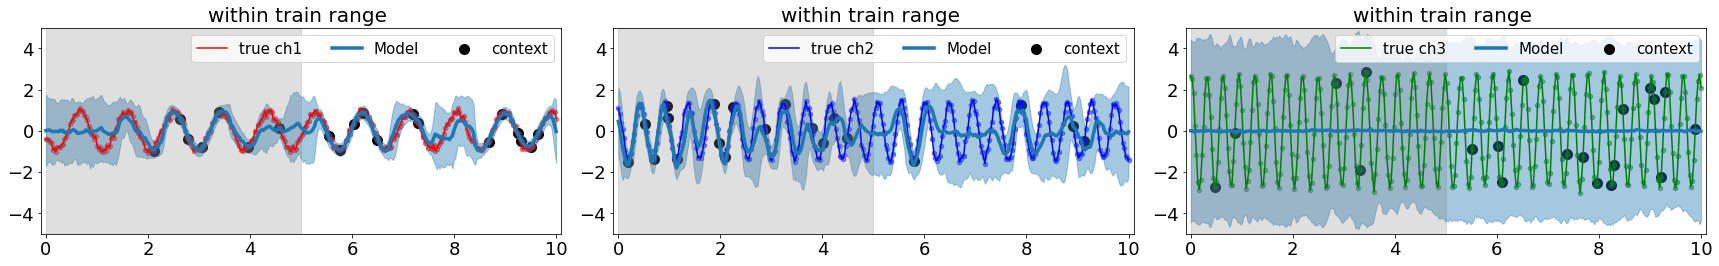

In [43]:
#------------------------------------------------------
#intrain context
#------------------------------------------------------
#ncontext,ntarget = 10,100
#gen_cls.testtype = 'extra_all'
nbatch=2
#ncontext,ntarget = 25,100
ncontext,ntarget = 20,100
ylim_ = [-5,5]


gen_cls.testtype = testtype[:-1]
context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
                                                                         ncontext=ncontext,
                                                                         ntarget=ntarget,
                                                                         train_range = train_range,
                                                                         test_range = test_range, 
                                                                         noise_true = True,
                                                                         intrain = False)


model_convcnp.eval()
model_tmp.eval()

y_mean0, y_std0 = model_convcnp(context_x.cuda(),context_y.cuda(),full_x.cuda())
y_mean1, y_std1 = model_tmp(context_x.cuda(),context_y.cuda(),full_x.cuda())
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=0.0001)
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=1.0)


y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[0],y_std0.cpu().data.numpy()[0]
y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[0],y_std1.cpu().data.numpy()[0]



context_x_1 = context_x.cpu().data.numpy()[0]
context_y_1 = context_y.cpu().data.numpy()[0]
target_x_1 = target_x.cpu().data.numpy()[0]
target_y_1 = target_y.cpu().data.numpy()[0]
full_x_1 = full_x.cpu().data.numpy()[0]
full_y_1 = full_y.cpu().data.numpy()[0]


nbatch=1


print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype[0] == 'i':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype[0] == 'e':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
#         plt.scatter(context_x[bidx,:,j],context_y[bidx,:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
#         plt.plot(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
#         plt.scatter(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
#         plt.plot(full_x[bidx,:,j],y_mean[bidx,:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x[bidx,:,j],
#                          y_mean[bidx,:,j] + 2 * y_std[bidx,:,j],
#                          y_mean[bidx,:,j] - 2 * y_std[bidx,:,j],
#                          color='tab:blue', alpha=alpha_)


        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




print('#'*100)
y_mean,y_std = y_mean1_1,y_std1_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype[0] == 'i':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype[0] == 'e':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




####################################################################################################


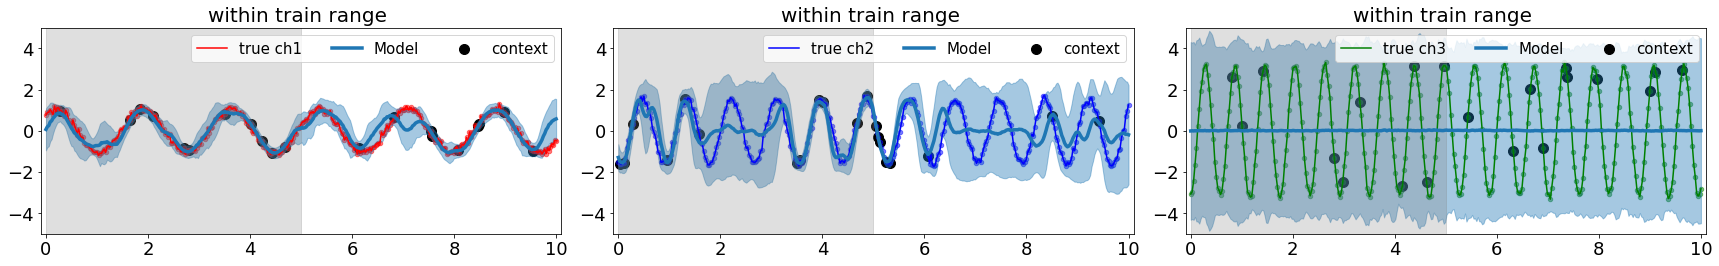

####################################################################################################


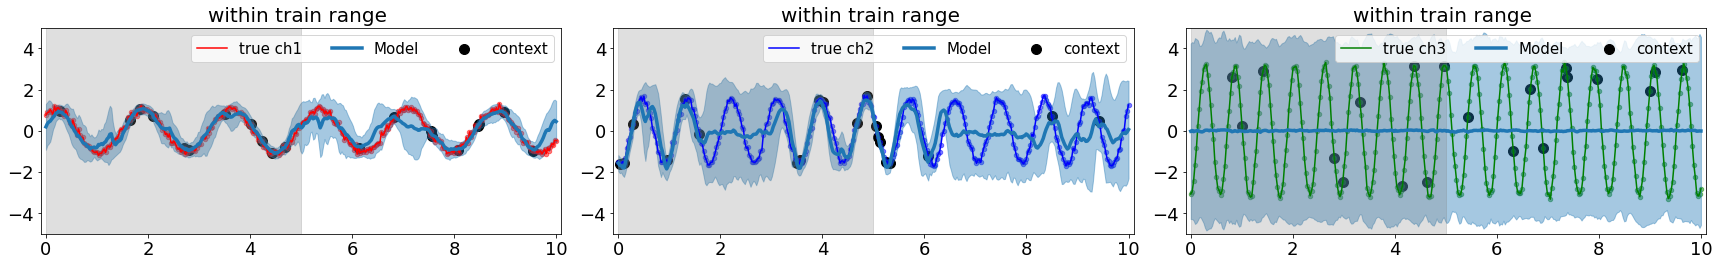

In [45]:
# gen_cls.testtype = testtype[:-1]
# context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
#                                                                          ncontext=ncontext,
#                                                                          ntarget=ntarget,
#                                                                          train_range = train_range,
#                                                                          test_range = test_range, 
#                                                                          noise_true = False,
#                                                                          intrain = False)



model_convcnp.eval()
model_tmp.eval()


y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[1],y_std0.cpu().data.numpy()[1]
y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[1],y_std1.cpu().data.numpy()[1]


context_x_1 = context_x.cpu().data.numpy()[1]
context_y_1 = context_y.cpu().data.numpy()[1]
target_x_1 = target_x.cpu().data.numpy()[1]
target_y_1 = target_y.cpu().data.numpy()[1]
full_x_1 = full_x.cpu().data.numpy()[1]
full_y_1 = full_y.cpu().data.numpy()[1]



nbatch=1


print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1

fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype[0] == 'i':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype[0] == 'e':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        


        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




print('#'*100)
y_mean,y_std = y_mean1_1,y_std1_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype[0] == 'i':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype[0] == 'e':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()




In [46]:
from model_gpbaseline import validate_oracle_epochs_with_dict,gp_predict_batch

# def gaussian_sampler(mu,std,num_sample =5):
#     sample_list = []
#     for i in range(num_sample):
#         tmp = mu + std*torch.randn_like(std)
#         sample_list.append(tmp[None,:,:])
#     return torch.cat(sample_list,dim=0).squeeze()

#xlim_ = [0-0.1,10+0.1]
color_list = ['red','blue','green']

figsiz_ = (24,3.8)

train_range = gen_cls.train_range
test_range = gen_cls.test_range
nbatch=1
#xlim_ = [test_range[0]-0.1,test_range[1]+0.1]
xlim_ = [gen_cls.full_range[0]-0.1,gen_cls.full_range[1]+0.1]
#ylim_ = [-2,2]
ylim_ = [-4,4]

alpha_=0.4

fontsiz_ = 15
fontsiz__ = 18

#------------------------------------------------------
# intrain context
#------------------------------------------------------
#ncontext,ntarget = 8,42
ncontext,ntarget = 15,100
#ncontext,ntarget = 25,100


gen_cls.testtype = testtype[:-1]
context_x,context_y,target_x,target_y,full_x,full_y = gen_cls.prepare_task(nbatch=nbatch,
                                                                         ncontext=ncontext,
                                                                         ntarget=ntarget,
                                                                         train_range = train_range,
                                                                         test_range = test_range,                                                                         
                                                                         noise_true= False,
                                                                         intrain = True)




model_convcnp.eval()
model_tmp.eval()

#y_mean0, y_std0 = model_convcnp(context_x.cuda(),context_y.cuda(),full_x.cuda())
y_mean1, y_std1 = model_tmp(context_x.cuda(),context_y.cuda(),full_x.cuda(),seperate=True)
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=0.0001)
#y_mean1, y_std1 = model(context_x.cuda(),context_y.cuda(),full_x.cuda(),noise_err=1.0)


y_mean0_1,y_std0_1 = y_mean1[0].cpu().data.numpy().squeeze(),y_std1[0].cpu().data.numpy().squeeze()
y_mean1_1,y_std1_1 = y_mean1[1].cpu().data.numpy().squeeze(),y_std1[1].cpu().data.numpy().squeeze()


context_x_1 = context_x.cpu().data.numpy()[0]
context_y_1 = context_y.cpu().data.numpy()[0]
target_x_1 = target_x.cpu().data.numpy()[0]
target_y_1 = target_y.cpu().data.numpy()[0]
full_x_1 = full_x.cpu().data.numpy()[0]
full_y_1 = full_y.cpu().data.numpy()[0]


#nbatch=1

print('#'*100)
y_mean,y_std = y_mean0_1,y_std0_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'

        #true
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        #model       
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()



print('#'*100)
y_mean,y_std = y_mean1_1,y_std1_1


fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

for bidx in range(nbatch):
    for j in range(nchannels):
        plt.subplot(1,3,bidx*nchannels + (j+1))
        
        #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
        if gen_cls.testtype == 'inter':
            plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
            plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        if gen_cls.testtype == 'extra':
            plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
        #dataset
        plt.scatter(context_x_1[:,j],context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'

        #true
        plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
        plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        #model       
        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
        plt.fill_between(full_x_1[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=alpha_)

        
        
        plt.ylim(ylim_)
        plt.xlim(xlim_)
        plt.xticks(fontsize =  fontsiz__)
        plt.yticks(fontsize = fontsiz__)
        #if j == 0:
        plt.legend(fontsize=fontsiz_,ncol=3)


        plt.title('within train range ',fontsize= 20)
            
            
fig.tight_layout()    
#plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()


NameError: name 'cc_mean' is not defined

In [86]:
# #xlim_ = [0-0.1,10+0.1]

# figsiz_ = (24,3.8)

# train_range = gen_cls.train_range
# test_range = gen_cls.test_range
# nbatch=2
# #xlim_ = [test_range[0]-0.1,test_range[1]+0.1]
# xlim_ = [gen_cls.full_range[0]-0.1,gen_cls.full_range[1]+0.1]
# #ylim_ = [-2,2]
# #ylim_ = [-4,4]

# fontsiz_ = 15
# fontsiz__ = 18

# #------------------------------------------------------
# # intrain context
# #------------------------------------------------------


# nbatch=1


# model.eval()
# #y_mean0_1,y_std0_1 = y_mean0.cpu().data.numpy()[1],y_std0.cpu().data.numpy()[1]
# y_mean1_1,y_std1_1 = y_mean1.cpu().data.numpy()[1],y_std1.cpu().data.numpy()[1]


# context_x_1 = context_x.cpu().data.numpy()[1]
# context_y_1 = context_y.cpu().data.numpy()[1]
# target_x_1 = target_x.cpu().data.numpy()[1]
# target_y_1 = target_y.cpu().data.numpy()[1]
# full_x_1 = full_x.cpu().data.numpy()[1]
# full_y_1 = full_y.cpu().data.numpy()[1]



# # print('#'*100)
# # y_mean,y_std = y_mean0_1,y_std0_1

# # fig = plt.figure(figsize=figsiz_)
# # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

# # for bidx in range(nbatch):
# #     for j in range(nchannels):
# #         plt.subplot(1,3,bidx*nchannels + (j+1))
        
# #         #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
# #         if gen_cls.testtype == 'inter':
# #             plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
# #             plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
# #         if gen_cls.testtype == 'extra':
# #             plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
# # #         #dataset
# # #         plt.scatter(context_x[bidx,:,j],context_y[bidx,:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
# # #         plt.plot(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
# # #         plt.scatter(full_x[bidx,:,j],full_y[bidx,:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
# # #         plt.plot(full_x[bidx,:,j],y_mean[bidx,:,j],color='tab:blue',linewidth=3.5,label = 'Model')
# # #         plt.fill_between(full_x[bidx,:,j],
# # #                          y_mean[bidx,:,j] + 2 * y_std[bidx,:,j],
# # #                          y_mean[bidx,:,j] - 2 * y_std[bidx,:,j],
# # #                          color='tab:blue', alpha=alpha_)


# #         #dataset
# #         plt.scatter(context_x_1[:,j],0*context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
# #         #plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
# #         #plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
# #         #plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
# #         plt.fill_between(full_x_1[:,j],
# #                          0*y_mean[:,j] + 2 * y_std[:,j],
# #                          0*y_mean[:,j] - 2 * y_std[:,j],
# #                          color='tab:blue', alpha=alpha_)

        
        
# #         plt.ylim(ylim_)
# #         plt.xlim(xlim_)
# #         plt.xticks(fontsize =  fontsiz__)
# #         plt.yticks(fontsize = fontsiz__)
# #         #if j == 0:
# #         plt.legend(fontsize=fontsiz_,ncol=3)


# #         plt.title('within train range ',fontsize= 20)
            
            
# # fig.tight_layout()    
# # #plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

# # plt.show()




# print('#'*100)
# y_mean,y_std = y_mean1_1,y_std1_1


# fig = plt.figure(figsize=figsiz_)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.7)

# for bidx in range(nbatch):
#     for j in range(nchannels):
#         plt.subplot(1,3,bidx*nchannels + (j+1))
        
#         #plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train region')
#         if gen_cls.testtype == 'inter':
#             plt.axvspan(xmin = train_range[0],xmax = test_range[0], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
#             plt.axvspan(xmin = test_range[1],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         if gen_cls.testtype == 'extra':
#             plt.axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25)
        
#         #dataset
#         plt.scatter(context_x_1[:,j],0*context_y_1[:,j],color = 'k',s=100,label = 'context') #,marker='s'
        
# #         plt.plot(full_x_1[:,j],full_y_1[:,j],color=color_list[j],linewidth=1.5,label = 'true ch{}'.format(j+1) )    
# #         plt.scatter(full_x_1[:,j],full_y_1[:,j],color=color_list[j],s=20.0,alpha=0.5)
        
        
# #        plt.plot(full_x_1[:,j],y_mean[:,j],color='tab:blue',linewidth=3.5,label = 'Model')
#         plt.fill_between(full_x_1[:,j],
#                          0*y_mean[:,j] + 2 * y_std[:,j],
#                          0*y_mean[:,j] - 2 * y_std[:,j],
#                          color='tab:blue', alpha=alpha_)

        
        
#         plt.ylim(ylim_)
#         plt.xlim(xlim_)
#         plt.xticks(fontsize =  fontsiz__)
#         plt.yticks(fontsize = fontsiz__)
#         #if j == 0:
#         plt.legend(fontsize=fontsiz_,ncol=3)


#         plt.title('within train range ',fontsize= 20)
            
            
# fig.tight_layout()    
# #plt.savefig('./'+tasktype + '_within_trainrange_extra_'+model_type  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

# plt.show()


In [87]:



# x_grid = model.compute_xgrid(context_x[:3].cuda(),context_y[:3].cuda(),full_x[:3].cuda())
# nh_sm,h1,h0 = model.encoder(context_x[:3].cuda(), context_y[:3].cuda(), x_grid)
# nh_sm_v1 =  model.compute_hgrid_tmp(nh_sm,option = 'mean')
# nh_sm_v1 = nh_sm_v1.reshape(nh_sm_v1.size(0),nh_sm_v1.size(1),-1)

# nh_sm_v2 =  model.compute_hgrid_tmp(h0,option = 'var')
# nh_sm_v2 = nh_sm_v2.reshape(nh_sm_v2.size(0),nh_sm_v2.size(1),-1)


# ib = 0
# fontsiz_=19
# plt.figure(figsize=(20,3*3))

# plt.subplot(4,1,1)        
# for i in range(9):
#     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),h0[ib,:,i].cpu().data.numpy(),label = str(i))    
#     plt.scatter(context_x[ib,:,i%3].cpu().data.numpy(),0*context_y[ib,:,i%3].cpu().data.numpy(),label = str(i))
    
#     #plt.scatter(context_x[ib,i].cpu().data.numpy(),context_y[ib,i].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('h0',fontsize=fontsiz_)            
# plt.legend()        

# plt.subplot(4,1,2)        
# for i in range(9):
#     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),nh_sm_v2[ib,:,i].cpu().data.numpy(),label = str(i))    
#     #plt.scatter(context_x[ib,i].cpu().data.numpy(),context_y[ib,i].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('h0',fontsize=fontsiz_)            
# plt.legend()        


# plt.subplot(4,1,3)
# for i in range(9):
#     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),nh_sm[ib,:,i].cpu().data.numpy(),label = str(i))
#     plt.scatter(context_x[ib,:,i%3].cpu().data.numpy(),context_y[ib,:,i%3].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('h1',fontsize=fontsiz_)    
# plt.legend()        
    

    
# nh_sm_c = get_convolved_h(nh_sm)    
# plt.subplot(4,1,4)
# for i in range(9):
#     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),nh_sm_c[ib,:,i].cpu().data.numpy(),label = str(i))
#     plt.scatter(context_x[ib,:,i%3].cpu().data.numpy(),context_y[ib,:,i%3].cpu().data.numpy(),label = str(i))    
#     #plt.scatter(context_x[ib,:,i%3].cpu().data.numpy(),context_y[ib,:,i%3].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('h1_convolved',fontsize=fontsiz_)    
# #plt.legend()        
# #plt.ylim([-3,3])        
    

# print('\n'*2)
    
    
    
# #ib = 0
# #fontsiz_=19
# # plt.figure(figsize=(20,4))
# # plt.subplot(2,1,1)
# # #for i in range(3):
# # for i in range(9):
# #     plt.plot(x_grid[ib,:,i//3].cpu().data.numpy(),nh_sm[ib,:,i].cpu().data.numpy(),label = str(i))
# #     if i == 0:
# #         plt.title('model.encoder',fontsize=fontsiz_)    
# # plt.legend()        
        
# # plt.subplot(2,1,2)        
# # for i in range(3):
# #     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),nh_sm[ib,:,i].cpu().data.numpy(),label = str(i))
# #     if i == 0:
# #         plt.title('model.encoder',fontsize=fontsiz_)    
        
# # plt.legend()        
# plt.show()
# print('\n'*2)

# ib = 0
# plt.figure(figsize=(20,3*2))
# plt.subplot(2,1,1)
# for i in range(nh_sm_v1.size(-1)):
# #for i in range(4,6):    
#     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),nh_sm_v1[ib,:,i].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('model.compute_hgrid',fontsize=fontsiz_)    
# plt.legend()        


# plt.subplot(2,1,2)
# for i in range(nh_sm_v2.size(-1)):
# #for i in range(4,6):    
#     plt.plot(x_grid[ib,:,i%3].cpu().data.numpy(),nh_sm_v2[ib,:,i].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('model.compute_hgrid',fontsize=fontsiz_)    
# plt.legend()        

# plt.show()



# print('\n'*3)

In [122]:
from torch.fft import rfftn, irfftn,rfft, irfft

def get_convolved_h(h_grid):    
    nb,ngrid,nkernels = h_grid.size()
    #permuted_index = np.random.permutation(nkernels)    
    
    p = np.random.randint(1,nkernels)
    permuted_index = np.roll(np.arange(nkernels),p)
    
    return convolve_1d_functional_h(h_grid,h_grid[:,:,permuted_index])



def convolve_1d_functional_h(h_i,h_j,target_dim=1,eps=1e-4):
    """
    inputs
        h_i : (nb,ngrids,nchannel)
        h_j : (nb,ngrids,nchannel)    
    outputs
        h_ij : (nb,ngrids,nchannel)
    """
    #nhiddens = h_i.size(1)
    nhiddens = h_i.size(target_dim)
    
    if nhiddens % 2 != 0:
        nhiddens -= 1
        h_i = h_i[:,:-1,:]
        h_j = h_j[:,:-1,:]    
    
    f_h_i = rfft(h_i,dim=target_dim)
    f_h_j = rfft(h_j,dim=target_dim)

    #plt.scatter(i,(torch.roll(a,shifts=i,dims=-1)*b).sum(dim=1))
#     f_h_i.imag *= -1    
#     n_ij_conv = irfft((f_h_i*f_h_j),dim=target_dim)        

    
    #plt.scatter(i,(a*torch.roll(b,shifts=i,dims=-1)).sum(dim=1))
    f_h_j.imag *= -1    
    n_ij_conv = irfft((f_h_i*f_h_j),dim=target_dim)        
    #n_ij_conv = irfft((f_h_i*f_h_j),dim=target_dim) / (h_i.norm(dim=-1,keepdim=True)*h_j.norm(dim=-1,keepdim=True) + eps)       
    
    #return n_ij_conv/(n_ij_conv.norm(dim=-1,keepdim=True) + eps)
    #return n_ij_conv/(h_i.norm(dim=-1,keepdim=True)*h_j.norm(dim=-1,keepdim=True) + eps)
    return (n_ij_conv-n_ij_conv.mean(dim=1,keepdim=True))/(n_ij_conv.std(dim=1,keepdim=True) + eps)
    #return n_ij_conv

In [123]:
#nh_sm.size()

In [58]:
# x_grid = model.compute_xgrid(context_x.cuda(),context_y.cuda(),target_x.cuda())
# #n_h,n_h1,x_grid = model.encoder(context_x[:3].cuda(), context_y[:3].cuda(), x_grid)
# # n_h0,n_h1,(h0,h1),(h0_c,h1_c),x_grid = model.encoder(context_x[:3].cuda(), context_y[:3].cuda(), x_grid)
# # n_h0,n_h1,(h0,h1),(h0_c,h1_c),x_grid = model.encoder(context_x[:3].cuda(), context_y[:3].cuda(), x_grid)


# nh_sm,_,_ = model.encoder(context_x.cuda(), context_y.cuda(), x_grid)
# nh_sm_v1 = model.compute_hgrid(nh_sm)
# nh_sm_v1 = nh_sm_v1.view(nh_sm.size(0),nh_sm.size(1),-1)
     

    
    
# ib = 0
# fontsiz_=19
# plt.figure(figsize=(20,4))
# for i in range(9):
# #for i in range(4,6):    
#     plt.plot(nh_sm[ib,:,i].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('convolution',fontsize=fontsiz_)    
# plt.legend()        
# plt.show()
# print('\n'*2)

# ib = 0
# plt.figure(figsize=(20,4))
# for i in range(9):
# #for i in range(4,6):    
#     plt.plot(nh_sm_v1[ib,:,i].cpu().data.numpy(),label = str(i))
#     if i == 0:
#         plt.title('convolution',fontsize=fontsiz_)    
# plt.legend()        
# plt.show()
# print('\n'*5)